## 利用ARIMA对黄金与比特币的价格进行预测

使用ARIMA工具比特币与黄金价格进行预测：

1，数据加载&分析处理：黄金数据存在缺失，主要是每年的两天节假日，由于非工作日价格不会变化，故我们按照前一天的值进行赋值；
且由于黄金在非工作日时即在周末没有数据，我们按周五的价格进行数据增强，添加到表格中。

2，模型选择&训练，在给定范围内，选择最优的超参数
创建ARMA时间序列模型。我们并不知道p和q取什么值时，模型最优，因此可以给它们设置一个区间范围，比如都是range(0,3)，然后计算不同模型的AIC数值，选择最小的AIC数值对应的那个ARMA模型

3，模型预测，可视化呈现
用这个最优的ARMA模型预测黄金与比特币分别的每天的价格，并将结果做可视化呈现。（预测默认选择当前天之前的数据进行）

### 导入相关库

In [1130]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA 
from arch.unitroot import ADF
import statsmodels.api as sm
import datetime
from itertools import product
from datetime import  timedelta
import calendar
import warnings                                  # do not disturbe mode
warnings.filterwarnings('ignore')
import PyQt5
%matplotlib qt5
warnings.filterwarnings('ignore')
matplotlib.rcParams['font.family'] = 'SimHei'#支持显示中文
plt.rcParams['axes.unicode_minus'] = False #支持显示中文

### Step1 数据加载与分析

In [1193]:
bitcoin = pd.read_csv(r'BCHAIN-MKPRU.csv', index_col=['Date'], parse_dates=True)#读取比特币数据
gold = pd.read_csv(r'LBMA-GOLD.csv', index_col=['Date'], parse_dates=True)#读取黄金数据
# data=gold.dropna()#删除缺失值，默认行
# df = gold["USD (PM)"].fillna( method='ffill',inplace = True) #使用上一个值来进行替代，inplace意为直接在原始数据中进行修改
df3=bitcoin
# df1[df1["USD (PM)"].isnull()]#判断缺失数据

### 黄金数据增强

先判断数据是否缺失，然后用上一天数据进行填充，再将周末对应的日期加入数表格中，对应价格选对应周五的填充

In [1194]:
# gold[gold["USD (PM)"].isnull()] #判断缺失值
gold["USD (PM)"].fillna( method='ffill',inplace = True) #使用上一个值来进行替代，inplace意为直接在原始数据中进行修改
#创建DataFrame数据，包括index列和value列，其中index列为日期，但是格式为string格式
data = gold#pd.DataFrame(data={'index':['2021-1-01','2020-10-10','2020-10-17','2020-10-15'],'value':range(4)})

date_list1=[]
#计算最小日期和最大日期
date_start =data.index.min().strftime('%Y-%m-%d')
date_end =data.index.max().strftime('%Y-%m-%d')
#date_end - date_start#
#根据最小日期和最大日期，计算日期间隔，由于date_start和date_end为string类型，因此需要先更改为日期类型
delta =datetime.datetime.strptime(date_end, "%Y-%m-%d")-datetime.datetime.strptime(date_start, "%Y-%m-%d")

for i in range(1,delta.days+1):
    date =(datetime.datetime.strptime(date_end, "%Y-%m-%d")-datetime.timedelta(days=i)).strftime('%Y-%m-%d')
    #如果数据缺失，则补数
    if(date not in data.index.strftime('%Y-%m-%d')):
        date_list1.append(datetime.datetime.strptime(date,('%Y-%m-%d')))
    future = pd.DataFrame(index=date_list1, columns= data.columns)
    df_month2 = pd.concat([data, future])
#按照日期列排序
dd=df_month2.sort_index(ascending=True)#根据日期排序
#工作日的价格为上一天即这个周五的价格
dd["USD (PM)"].fillna( method='ffill',inplace = True) #使用上一个值来进行替代，inplace意为直接在原始数据中进行修改
gold=dd

### 这里可以按周期对数据进行统计（可以使用也可以不使用）

In [1195]:
# 按照月，季度，年来统计
df=dd#黄金数据统计
dd2=bitcoin
df1=dd2#比特币数据统计
df_month = df.resample('M').mean()
df_month#跟df相比  数据少了很多 因为是按照一个月统计一次  按照每个月的平均值来统计

df_Q = df.resample('Q-DEC').mean()
df_Q#这个是按照季度

df_year = df.resample('A-DEC').mean()
df_year# 这个是按照年份 一年统计一次
#比特币
df_month1 = df1.resample('M').mean()
df_month1#跟df相比  数据少了很多 因为是按照一个月统计一次  按照每个月的平均值来统计

df_Q1 = df1.resample('Q-DEC').mean()
df_Q1#这个是按照季度

df_year1 = df1.resample('A-DEC').mean()
df_year1# 这个是按照年份 一年统计一次

#黄金价格可视化
# 按照天，月，季度，年来显示沪市指数的走势
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Gold Daily Price', fontsize=20) 
plt.subplot(221)
plt.plot(df["USD (PM)"], '-', label='byDay')
plt.legend()
plt.subplot(222)
plt.plot(df_month["USD (PM)"], '-', label='byMonth')
plt.legend()
plt.subplot(223)
plt.plot(df_Q["USD (PM)"], '-', label='bySeason')
plt.legend()
plt.subplot(224)
plt.plot(df_year["USD (PM)"], '-', label='byYear')
plt.legend()
plt.show()

#比特币价格可视化
# 按照天，月，季度，年来显示沪市指数的走势
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin Daily Price', fontsize=20)
plt.subplot(221)
plt.plot(df1["Value"], '-', label='byDay')
plt.legend()
plt.subplot(222)
plt.plot(df_month1["Value"], '-', label='byMonth')
plt.legend()
plt.subplot(223)
plt.plot(df_Q1["Value"], '-', label='bySeason')
plt.legend()
plt.subplot(224)
plt.plot(df_year1["Value"], '-', label='byYear')
plt.legend()
plt.show()

## ARIMA 时间序列分析&模型选择&训练

主要是输入的数据必须为平稳序列，先进行平稳性分析，若不平稳，就选取差分作为输入，然后确定ARIMA(data,(p,d,q))中p d q的分别取值

### 数据时间序列平稳性分析

#### 差分图分析

In [1120]:
bitcoin["diff1"] = bitcoin["Value"].diff(1).dropna()#1阶差分
bitcoin["diff2"] = bitcoin["Value"].diff(2).dropna()#2阶差分
# data["diff3"] = data["diff2"].diff(1).dropna()#2阶差分
# data["diff4"] = data["diff3"].diff(1).dropna()#2阶差分
# fig=plt.figure(figsize=(12,8))
bitcoin1 = bitcoin.loc[:,["Value","diff1","diff2"]]#,"diff3","diff4"
bitcoin1.plot(subplots=True, figsize=(12, 8),title="Bitcoin data difference diagram",fontsize=15)
# plt.legend(prop={'family' : 'Times New Roman', 'size'   : 12})
# plt.yticks(fontproperties = 'Times New Roman', size = 20)
#fontsize设置坐标轴字体大小  figsize设置图片大小，subplots=True根据dataframe的columns绘制子图
gold["diff1"] = gold["USD (PM)"].diff(1).dropna()#1阶差分
gold["diff2"] = gold["USD (PM)"].diff(2).dropna()#2阶差分
# data["diff3"] = data["diff2"].diff(1).dropna()#2阶差分
# data["diff4"] = data["diff3"].diff(1).dropna()#2阶差分
gold1 = gold.loc[:,["USD (PM)","diff1","diff2"]]#,"diff3","diff4"
gold1.plot(subplots=True, figsize=(12, 8),title="Gold data difference diagram",fontsize=15)

# plt.legend(prop={'family' : 'Times New Roman', 'size'   : 12})

#从图中可以看出一阶差分比二阶和原数据更平稳  故参数d=1

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

#### PCF ACF图分析（可不进行：确定d参数的另一种方法）

In [1128]:
#ARIMA模型分析：
#先把ACF图和PACF图画出来看看：
fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig=sm.graphics.tsa.plot_acf(bitcoin["Value"].diff(2).iloc[1:len(list(bitcoin["Value"]))-1].dropna(),lags=24,ax=ax1) # 注意：要去掉第1个空值                             
ax2=fig.add_subplot(212)
fig=sm.graphics.tsa.plot_pacf(bitcoin["Value"].diff(2).iloc[1:len(list(bitcoin["Value"]))-1].dropna(),  lags=24,ax=ax2)# 注意：要去掉第1个空值
#判断：ACF图在2之后截尾，而PACF拖尾。模型可以由MA(2)→ARIMA(0,1,2).
#自相关（ACF）图和偏自相关（PACF）图

#### 单根检验

In [1136]:
print("单位根检验:\n")
print("比特币:",'\n',ADF(bitcoin.diff1.dropna()),'\n')  
print("黄金:",'\n',ADF(gold.diff1.dropna()))  


单位根检验:

比特币: 
    Augmented Dickey-Fuller Results   
Test Statistic                 -8.535
P-value                         0.000
Lags                               23
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

黄金: 
    Augmented Dickey-Fuller Results   
Test Statistic                -15.300
P-value                         0.000
Lags                                8
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


#### 白噪声检验

In [1141]:
#白噪声检验
from statsmodels.stats.diagnostic import acorr_ljungbox
print("黄金白噪声检验:\n")
a=acorr_ljungbox(gold.diff1.dropna(), lags = [i for i in range(1,12)],boxpierce=True)
print(a,'\n')
print("比特币噪声检验:\n")
a=acorr_ljungbox(bitcoin.diff1.dropna(), lags = [i for i in range(1,12)],boxpierce=True)
print(a,'\n')

黄金白噪声检验:

(array([ 0.82643976,  1.2812529 ,  2.32915309,  2.59852692,  3.17948667,
       20.08590122, 21.69494424, 30.87218311, 37.86911705, 38.15278848,
       38.19666728]), array([3.63304034e-01, 5.26962205e-01, 5.06958967e-01, 6.27084096e-01,
       6.72336552e-01, 2.67355458e-03, 2.86686965e-03, 1.48055577e-04,
       1.83993956e-05, 3.56962577e-05, 7.24761348e-05]), array([ 0.82508197,  1.27889881,  2.32392961,  2.59241831,  3.17115095,
       20.00349577, 21.60460813, 30.73158829, 37.68637204, 37.96817925,
       38.01174566]), array([3.63698494e-01, 5.27582828e-01, 5.07952136e-01, 6.28166773e-01,
       6.73618591e-01, 2.76543080e-03, 2.97113634e-03, 1.56824421e-04,
       1.98403764e-05, 3.84388094e-05, 7.78800575e-05])) 

比特币噪声检验:

(array([10.78496941, 18.93418697, 19.71443041, 20.96828975, 20.98475044,
       21.89556229, 21.92452112, 31.25363529, 35.10239476, 44.01252436,
       45.06460641]), array([1.02327596e-03, 7.73559171e-05, 1.94515086e-04, 3.21286439e-04,
       8.

### 模型参数寻优

In [1144]:
# 设置参数范围
ps = range(0, 5)
qs = range(0, 5)
ds = range(1, 2) #d=1  表示使用稳定的一阶差分
parameters = product(ps, ds, qs)
parameters_list = list(parameters)
print('parameters_list',parameters_list,type(parameters_list))

# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷
for param in parameters_list:#去遍历parameters_list里面的值 
    try:
        # SARIMAX 包含季节趋势因素的ARIMA模型
        model = ARIMA(df["USD (PM)"],#_month
                                order=(param[0], param[1], param[2])).fit(disp=False)                   
    except ValueError:
        print('参数错误:', param)
        continue      
    aic = model.aic#打擂法寻找最小的aic的模型
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param  
    results.append([param, model.aic])
# 输出最优模型
print('黄金最优模型: ', best_model.summary())
#比特币
results = []
best_aic = float("inf") # 正无穷
for param in parameters_list:#去遍历parameters_list里面的值 
    try:
        model1 = ARIMA(df1["Value"],#_month1
                                order=(param[0], param[1], param[2]) ).fit(disp=False)
    except ValueError:
        print('参数错误:', param)
        continue
    aic1 = model1.aic#打擂法寻找最小的aic的模型
    if aic < best_aic:
        best_model1 = model1
        best_aic1 = aic1
        best_param1 = param  
    results.append([param, model1.aic])
# 输出最优模型
print('比特币最优模型: ', best_model1.summary())
print("黄金最优参数:",best_param,"比特币最优参数:",best_param1)


parameters_list [(0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 1, 4), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 1, 4), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 1, 3), (2, 1, 4), (3, 1, 0), (3, 1, 1), (3, 1, 2), (3, 1, 3), (3, 1, 4), (4, 1, 0), (4, 1, 1), (4, 1, 2), (4, 1, 3), (4, 1, 4)] <class 'list'>
黄金最优模型:                               ARIMA Model Results                              
Dep. Variable:             D.USD (PM)   No. Observations:                 1824
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -7039.482
Method:                       css-mle   S.D. of innovations             11.478
Date:                Wed, 23 Feb 2022   AIC                          14090.964
Time:                        16:53:32   BIC                          14124.017
Sample:                    09-13-2016   HQIC                         14103.157
                         - 09-10-2021                                         
                       coef    std err          z   

### ARIMA时间序列预测,可视化呈现

#### 比特币预测

In [1213]:
df_month3= bitcoin[['Value']]#比特币  _month1
result = None
arima = ARIMA(bitcoin["Value"],best_param1)
result = arima.fit(disp=False)
pred = result.predict(start=2, end=len(df_month3)-1,typ='levels')
# 比特币指数预测结果显示

df_month3['forecast'] = result.predict(start=2, end=len(df_month3),typ='levels')  #best_model.get_prediction(start=0, end=len(df_month3)).predicted_mean
plt.figure(figsize=(30,7))
df3['Value'].plot(label='Real Stock Exchange Index')#实际的指数  
df_month3.forecast.plot(color='r', ls='--', label='pre Stock Exchange Index')#预测的指数
plt.legend()
plt.title('Bitcoin Exchange Index(day)')
plt.xlabel('time')
plt.ylabel('Exchange Index')
plt.show()

##### 比特币预测结果保存

In [211]:
df_month3.to_csv('Bitcone_pre_by_day.csv')

#### 黄金预测

In [1212]:
# df_month1USD (PM)
df_month4= gold#比特币  _month1 #[70:100] dd  df_month[['USD (PM)']] USD (PM)
result = None
arima = ARIMA(gold["USD (PM)"],(3,1,4))#dd  sm.tsa.ARMA ARIMA
result = arima.fit(disp=False)
# 黄金指数预测结果显示
df_month4['forecast'] = result.predict(start=1, end=len(df_month4),typ='levels')  #best_model.get_prediction(start=0, end=len(df_month3)).predicted_mean
plt.figure(figsize=(30,7))
df_month4["USD (PM)"].plot(color='b', ls='dotted', label='Real Stock Exchange Index')#实际的指数  _month3
df_month4.forecast.plot(color='r', ls='--', label='pre Stock Exchange Index')#预测的指数
plt.legend(prop={'family' : 'Times New Roman', 'size'   : 24})
plt.title('Gold Exchange Index(month)',fontproperties = 'Times New Roman', size = 24)
plt.xlabel('Time',fontproperties = 'Times New Roman', size = 24)
plt.ylabel('Exchange Index',fontproperties = 'Times New Roman', size = 24)
plt.yticks(fontproperties = 'Times New Roman', size = 14)
plt.xticks(fontproperties = 'Times New Roman', size = 14)
plt.show()

##### 黄金预测结果保存

In [ ]:
df_month4.to_csv('Gold_pre_by_day.csv')

In [ ]:
预测当天的价格,然后是模糊评价,然后关联规则得到购买概率 预测后三天时间的价格

#### 多预测未来N天黄金的价格并可视化

#### 将未来的N天对应的日期加到黄金dataframe的index中

In [1159]:
data = gold#pd.DataFrame(data={'index':['2021-1-01','2020-10-10','2020-10-17','2020-10-15'],'value':range(4)})
date_list1=[]
N=10#未来10天
date_start =data.index.min().strftime('%Y-%m-%d')
date_end =(data.index.max()+timedelta(days=N)).strftime('%Y-%m-%d')
#date_end - date_start#
#根据最小日期和最大日期，计算日期间隔，由于date_start和date_end为string类型，因此需要先更改为日期类型
delta =datetime.datetime.strptime(date_end, "%Y-%m-%d")-datetime.datetime.strptime(date_start, "%Y-%m-%d")
for i in range(1,delta.days+1):
    date =(datetime.datetime.strptime(date_end, "%Y-%m-%d")-datetime.timedelta(days=i)).strftime('%Y-%m-%d')
    #如果数据缺失，则补数
    if(date not in data.index.strftime('%Y-%m-%d')):
        date_list1.append(datetime.datetime.strptime(date,('%Y-%m-%d')))
    future = pd.DataFrame(index=date_list1, columns= data.columns)
    df_month2 = pd.concat([data, future])
#按照日期列排序
dr=df_month2.sort_index(ascending=True)#根据日期排序

#可视化
df_month9= dr#黄金 _month1 #[70:100] dd  df_month[['USD (PM)']] USD (PM)
result = None
arima = ARIMA(gold["USD (PM)"],(3,1,4))#dd  sm.tsa.ARMA ARIMA
result = arima.fit(disp=False)
# 黄金指数预测结果显示
df_month9['forecast'] = result.predict(start=1, end=len(df_month9),typ='levels')  #best_model.get_prediction(start=0, end=len(df_month3)).predicted_mean
plt.figure(figsize=(30,7))
df_month9["USD (PM)"].plot(color='b', ls='dotted', label='Real Stock Exchange Index')#实际的指数  _month3
df_month9.forecast.plot(color='r', ls='--', label='pre Stock Exchange Index')#预测的指数
plt.legend(prop={'family' : 'Times New Roman', 'size'   : 24})
plt.title('Gold Exchange Index(month)',fontproperties = 'Times New Roman', size = 24)
plt.xlabel('Time',fontproperties = 'Times New Roman', size = 24)
plt.ylabel('Exchange Index',fontproperties = 'Times New Roman', size = 24)
plt.yticks(fontproperties = 'Times New Roman', size = 14)
plt.xticks(fontproperties = 'Times New Roman', size = 14)
plt.show()

从图可以看出预测曲线比原值多了一节，即为多预测的N天，如果不明显，可以加大N试试；比特币代码同理。

####  预测未来月份的价格（按月份预测才使用，数据需要用之前按月份统计的数据:见0.1.4，下面是添加未来N个月的日期）以黄金为例

根据月份预测的代码需要用sm.tsa.statespace.SARIMAX 季节性预测函数

In [1216]:
# 设置future_day，需要预测的时间date_list
df_month2 = df_month[['USD (PM)']]#[['USD (PM)']]
future_month = 6#预测未来的月数
last_month = pd.to_datetime(df_month2.index[len(df_month2)-1])#取出原来的最后一天的具体日期
date_list = []
for i in range(future_month):
    # 计算下个月有多少天
    year = last_day.year#年份
    month = last_day.month#月份
    if month == 12:
        month = 1
        year = year+1
    else:
        month = month + 1
    next_month_days = calendar.monthrange(year, month)[1]
    #print(next_month_days)
    last_month = last_month + timedelta(days=next_month_days)
    date_list.append(last_month)
print('date_list=', date_list)
# 添加未来要预测的3个月
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])

date_list= [Timestamp('2021-10-31 00:00:00', freq='M'), Timestamp('2021-12-01 00:00:00', freq='M'), Timestamp('2022-01-01 00:00:00', freq='M'), Timestamp('2022-02-01 00:00:00', freq='M'), Timestamp('2022-03-04 00:00:00', freq='M'), Timestamp('2022-04-04 00:00:00', freq='M')]


In [1217]:
df_month9= df_month2#黄金  _month1
result = None
arima = sm.tsa.statespace.SARIMAX(df_month['USD (PM)'],order=best_param,enforce_stationarity=False,\
                                enforce_invertibility=False)
result = arima.fit(disp=False)
#print(result.params)
# pred = result.predict(start=2, end=len(df_month4)-1,typ='levels')
# 比特币指数预测结果显示
df_month9['forecast'] = result.predict(start=2, end=len(df_month9),typ='levels')

#可视化
# 黄金指数预测结果显示
plt.figure(figsize=(30,7))
df_month9["USD (PM)"].plot(color='b', ls='dotted', label='Real Stock Exchange Index')#实际的指数  _month3
df_month9.forecast.plot(color='r', ls='--', label='pre Stock Exchange Index')#预测的指数
plt.legend(prop={'family' : 'Times New Roman', 'size'   : 24})
plt.title('Gold Exchange Index(month)',fontproperties = 'Times New Roman', size = 24)
plt.xlabel('Time',fontproperties = 'Times New Roman', size = 24)
plt.ylabel('Exchange Index',fontproperties = 'Times New Roman', size = 24)
plt.yticks(fontproperties = 'Times New Roman', size = 14)
plt.xticks(fontproperties = 'Times New Roman', size = 14)
plt.show()

## 时间序列预测+逻辑回归决策:判断买入卖出分量   输出每日总资产

如果报错就再跑一次黄金的预测（0.2.3.2）与比特币的预测（0.2.3.1），原因可能是中途重复定义了变量，然后变化了。

In [1214]:
from numpy import *
filename='...\\testSet.txt' #文件目录
# df_month3=df_month1#比特币
# df = dd
# df1=bitcoin
# df_month4=gold#黄金
# df_month3=bitcoin
YT=2#预测第y天后的黄金或者比特币价格

def sigmoid(inX):  #sigmoid函数
    return 1.0/(1+exp(-inX))



Bgold=1000#黄金本金
Bbitcoin=1000#比特币本金

Ygold = 0.0225
Ybitcoin = 0.045

GCB=1000#现金
GGS=0#股数

BGS=0#股数
gold=df_month4
bitcoin=df_month3
FA=[1000,0,0,0]#0:C 1:G 2:B
HHH=0
x1=[]
y2=[]
y4=[]
y5=[]
y3=[]
y1=[]
for i in range(0,1825-YT):  
    Gll=(df_month4["forecast"][i+YT] - df_month4["USD (PM)"][i])/df_month4["USD (PM)"][i] #黄金今天的利润+YT
    Bll=(df_month3["forecast"][i+YT+1] - df_month3["Value"][i+1])/df_month3["Value"][i+1]#比特币今天的利润+YT
    #第二天跌 且跌得比佣金多 现在持股 则今天卖
    Pg=sigmoid((Gll-Ygold)*10)#比例 若大于0.5则赚否则赔    利率在 0.几 将其提高
    Pb=sigmoid((Bll-Ybitcoin)*10)#比例
    HHH=GGS*gold['USD (PM)'][i]+BGS*bitcoin['Value'][i+1]+GCB#总的钱
    if ((i%7)!=6) and  ((i%7)!=5):#工作日:
        if Pg>0.4 and Pb<0.5:#换仓或者买入
            Pg=1
            Pb=0
            HHH=GGS*gold['USD (PM)'][i]+BGS*bitcoin['Value'][i+1]+GCB#总的钱
            UU=(BGS*bitcoin['Value'][i+1])#需要换仓的资金-HHH*(Pb/(Pg+Pb)
            BGS=0#股数变化  BGS+
            GGS=GCB*(1-Ygold/2)/gold['USD (PM)'][i]+GGS+UU*(1-Ybitcoin/2-Ygold/2)/gold['USD (PM)'][i]#股数变化
            FA[2]=BGS*bitcoin['Value'][i+1]
            FA[1]=gold['USD (PM)'][i]*GGS
            FA[0]=GCB=0
        if Pg<0.5 and Pb>0.8:#换仓或者买入  比特币惩罚项:涨幅大    黄金投资稳定加激励项
            Pg=0
            Pb=1
            HHH=GGS*gold['USD (PM)'][i]+BGS*bitcoin['Value'][i+1]+GCB#总的钱
            UU=(GGS*gold['USD (PM)'][i])#需要换仓的资金
            GGS=0#股数变化  GGS+
            BGS=GCB*(1-Ybitcoin/2)/bitcoin['Value'][i+1]+BGS+UU*(1-Ybitcoin/2-Ygold/2)/bitcoin['Value'][i+1]#股数变化  
            FA[0]=GCB=0
            FA[2]=BGS*bitcoin['Value'][i+1]
            FA[1]=gold['USD (PM)'][i]*GGS
        if Pg>0.4 and Pb>0.8:#换仓或者买入 0.5 0.6
            HHH=GGS*gold['USD (PM)'][i]+BGS*bitcoin['Value'][i+1]+GCB#总的钱
            if (GGS*gold['USD (PM)'][i]/HHH) > (Pg/(Pg+Pb)):#现在的钱duo于分配钱
                UU=(GGS*gold['USD (PM)'][i])-HHH*(Pg/(Pg+Pb))#需要换仓的资金
                GGS=(Pg/(Pg+Pb))*HHH/gold['USD (PM)'][i]#股数变化  GGS+
                BGS=BGS+UU*(1-Ybitcoin/2-Ygold/2)/bitcoin['Value'][i+1]#股数变化  
                FA[0]=GCB=0
                FA[2]=BGS*bitcoin['Value'][i+1]
                FA[1]=gold['USD (PM)'][i]*GGS
                print("   :",(Pg/(Pg+Pb)))
            elif (BGS*bitcoin['Value'][i+1]/HHH) > (Pb/(Pg+Pb)):#比特币的钱多
                UU=(BGS*bitcoin['Value'][i+1])-HHH*(Pb/(Pg+Pb))#需要换仓的资金
                BGS=(Pb/(Pg+Pb))*HHH/bitcoin['Value'][i+1]#股数变化  BGS+
                GGS=GGS+UU*(1-Ybitcoin/2-Ygold/2)/gold['USD (PM)'][i]#股数变化
                FA[2]=BGS*bitcoin['Value'][i+1]
                FA[1]=gold['USD (PM)'][i]*GGS
                FA[0]=GCB=0
            else : #都没有持股
                BGS=(Pb/(Pg+Pb))*HHH*(1-Ybitcoin/2)/bitcoin['Value'][i+1]#股数变化  BGS+
                FA[2]=BGS*bitcoin['Value'][i+1]
                GGS=(Pg/(Pg+Pb))*HHH*(1-Ygold/2)/gold['USD (PM)'][i]#股数变化 GGS+
                FA[1]=gold['USD (PM)'][i]*GGS
                FA[0]=GCB=0
                print("   :",(Pg/(Pg+Pb)),(Pb/(Pg+Pb)),HHH,)
        if Pg<0.5 and Pb<0.5:#卖出
            GCB=GCB+GGS*gold['USD (PM)'][i]*(1-Ygold/2)#变现
            GGS=0
            GZT=0#观望状态
            GCB=GCB+BGS*bitcoin['Value'][i+1]*(1-Ybitcoin/2)#变现
            BGS=0
            BZT=0#观望状态
            FA[2]=BGS*bitcoin['Value'][i+1]
            FA[1]=gold['USD (PM)'][i]*GGS
            FA[0]=GCB
        
    else:#非工作日
        if Pb>0.8:#买入 0.6
            GGS=GGS
            BGS+=GCB*(1-Ybitcoin/2)/bitcoin['Value'][i+1]
            GCB=0
            FA[2]=BGS*bitcoin['Value'][i+1]
            FA[1]=gold['USD (PM)'][i]*GGS
            FA[0]=GCB
        if Pb<0.5:
            GCB+=BGS*bitcoin['Value'][i+1]*(1-Ybitcoin/2)
            BGS=0
            GGS=GGS
    y2.append(GGS)
    y3.append(BGS)
    FA[3]=HHH
    y1.append(FA[3])
#     y2.append()
    x1.append(gold.index[i])
    y4.append(GGS)
    y5.append(BGS)
    print(i,':',GCB,GGS,BGS,'  ',FA,'\n')#"佣金：",Ygold*gold['USD (PM)'][i]
#     GGS*
#     BBS*
w1=x1#用于最后绘制四种模型的资产对比图
ins=x1
v1=y1#list(df_month5['USD (PM)'])
values=y1
dictionary = dict(zip(ins, values))#列表变字典
df6 = pd.DataFrame(pd.Series(dictionary), columns=['fruits'])#字典变dataframe
df6

#绘制每日总资产
plt.figure(figsize=(15,7))
# df6["USD (PM)"].plot(label='Gjia')#实际的指数  _month3
df6.fruits.plot(color='b', ls='dotted', label='Total Assets')#收益率HHH
plt.legend(prop={'family' : 'Times New Roman', 'size'   : 24})
# plt.title('The yield',fontproperties = 'Times New Roman', size = 24)
plt.xlabel('Date',fontproperties = 'Times New Roman', size = 24)
plt.ylabel('Dollars',fontproperties = 'Times New Roman', size = 24)
plt.yticks(fontproperties = 'Times New Roman', size = 20)
plt.xticks(fontproperties = 'Times New Roman', size = 20)
plt.show()
SYL1=pow(HHH/1000,1/5)-1#计算 年化利率
SS=y1#保存了每天总资产
SS=[(SS1-min(SS))/(max(SS)-min(SS)) for SS1 in SS] #归一化
BZ1=np.std([x for x in SS], ddof = 1)#计算标准差
XPB1=(SYL1-0.0202)/BZ1#计算夏普比
print(SYL1,BZ1,XPB1)



0 : 0 0.7464517590215914 0    [0, 988.75, 0.0, 1000.0] 

1 : 0 0.7464517590215914 0    [0, 988.0408708289295, 0.0, 988.0408708289295] 

2 : 0 0.7464517590215914 0    [0, 986.6226124867885, 0.0, 986.6226124867885] 

3 : 0 0.7464517590215914 0    [0, 978.448965725502, 0.0, 978.448965725502] 

4 : 0 0.7464517590215914 0    [0, 976.6201589158991, 0.0, 976.6201589158991] 

5 : 0 0.7464517590215914 0    [0, 976.6201589158991, 0.0, 976.6201589158991] 

6 : 0.0 0.7464517590215914 0    [0, 976.6201589158991, 0.0, 976.6201589158991] 

7 : 0 0.7464517590215914 0    [0, 981.4720953495395, 0.0, 981.4720953495395] 

8 : 0 0.7464517590215914 0    [0, 980.6883210025668, 0.0, 980.6883210025668] 

9 : 0 0.7464517590215914 0    [0, 989.8696776385324, 0.0, 989.8696776385324] 

10 : 0 0.7464517590215914 0    [0, 999.573550505813, 0.0, 999.573550505813] 

11 : 0 0.7464517590215914 0    [0, 999.573550505813, 0.0, 999.2376472142535] 

12 : 0.0 0.7464517590215914 0    [0, 999.573550505813, 0.0, 999.23764721425

518 : 0.0 1.1129199420458877 0    [0, 1462.488095842501, 0.0, 1471.6140393672772] 

519 : 0.0 1.1129199420458877 0    [0, 1462.488095842501, 0.0, 1475.0084451905173] 

520 : 0 1.1129199420458877 0    [0, 1487.1392725588175, 0.0, 1487.1392725588175] 

521 : 0 1.1129199420458877 0    [0, 1487.1392725588175, 0.0, 1505.1685756199608] 

522 : 0 1.1129199420458877 0    [0, 1487.1392725588175, 0.0, 1504.7790536402447] 

523 : 0.0 1.1129199420458877 0    [0, 1487.1392725588175, 0.0, 1504.7790536402447] 

524 : 0.0 1.1129199420458877 0    [0, 1487.1392725588175, 0.0, 1504.7790536402447] 

525 : 0 1.1129199420458877 0    [0, 1498.6579939589924, 0.0, 1498.6579939589924] 

526 : 0 1.1129199420458877 0    [0, 1491.1457843501826, 0.0, 1491.1457843501826] 

527 : 0 1.1129199420458877 0    [0, 1480.7399828920536, 0.0, 1480.7399828920536] 

528 : 0 1.1129199420458877 0    [0, 1478.347205016655, 0.0, 1478.347205016655] 

529 : 0 1.1129199420458877 0    [0, 1477.9020370398366, 0.0, 1477.9020370398366] 



958 : 0.0 1.108898320768367 0    [0, 1424.0472235307368, 0.0, 1424.0472235307368] 

959 : 0 1.108898320768367 0    [0, 1418.8354014231254, 0.0, 1418.8354014231254] 

960 : 0 1.108898320768367 0    [0, 1421.9403167212768, 0.0, 1421.9403167212768] 

961 : 0 1.108898320768367 0    [0, 1423.6036642024294, 0.0, 1423.6036642024294] 

962 : 0 1.108898320768367 0    [0, 1409.354320780556, 0.0, 1409.354320780556] 

963 : 0 1.108898320768367 0    [0, 1409.354320780556, 0.0, 1417.7819480183955] 

964 : 0.0 1.108898320768367 0    [0, 1409.354320780556, 0.0, 1417.7819480183955] 

965 : 0.0 1.108898320768367 0    [0, 1409.354320780556, 0.0, 1417.7819480183955] 

966 : 0 1.108898320768367 0    [0, 1417.7819480183955, 0.0, 1417.7819480183955] 

967 : 0 1.108898320768367 0    [0, 1420.7205285684317, 0.0, 1420.7205285684317] 

968 : 0 1.108898320768367 0    [0, 1425.1561218515053, 0.0, 1425.1561218515053] 

969 : 0 1.108898320768367 0    [0, 1426.1541303401966, 0.0, 1426.1541303401966] 

970 : 0 1.10889

1433 : 0.0 1.1784759017614033 0    [0, 2291.841009950489, 0.0, 2291.841009950489] 

1434 : 0.0 1.1784759017614033 0    [0, 2291.841009950489, 0.0, 2291.841009950489] 

1435 : 0 1.1784759017614033 0    [0, 2324.9561827899843, 0.0, 2324.9561827899843] 

1436 : 0 1.1784759017614033 0    [0, 2367.2634676632188, 0.0, 2367.2634676632188] 

1437 : 2308.29695282371 0 0    [2308.29695282371, 0.0, 0.0, 2334.56076138934] 

1438 : 0 1.1843025255452058 0    [0, 2282.3286121044434, 0.0, 2308.29695282371] 

1439 : 0 1.1843025255452058 0    [0, 2279.0125650329164, 0.0, 2279.0125650329164] 

1440 : 0.0 1.1843025255452058 0    [0, 2279.0125650329164, 0.0, 2279.0125650329164] 

1441 : 0.0 1.1843025255452058 0    [0, 2279.0125650329164, 0.0, 2279.0125650329164] 

1442 : 0 1.1843025255452058 0    [0, 2302.2248945336028, 0.0, 2302.2248945336028] 

1443 : 0 1.1843025255452058 0    [0, 2263.37977169572, 0.0, 2263.37977169572] 

1444 : 0 1.1843025255452058 0    [0, 2289.1975667526053, 0.0, 2289.1975667526053] 

0.16526626923324117 0.284068052515182 0.5106743540810106


 灵敏度分析数据：改变黄金与比特币的佣金手续百分比，记录年利率，标准差，夏普比率

0.01 0.02         0.3551784194393226  0.30333854274872174  1.1043054944613833

0.015 0.03       0.2812282770872574  0.29117806973684196  0.8964558262343278

0.0175 0.035     0.24655972263367643 0.28793260180522473 0.786155236379936

0.02 0.04        0.17899526610003447   0.28838391225198373   0.5506384349251859  

0.0225 0.045     0.16526626923324117 0.284068052515182 0.5106743540810106

0.025 0.05       0.14462233063536156  0.27312093282604405   0.45555765113986535

0.03 0.06       -0.04340231724904664  0.2039655818715379  -0.311828675531663

x=[0.01,0.015,0.0175,0.02,0.0225,0.025,0.03,]

yy=[0.3551784194393226,0.2812282770872574,0.24655972263367643,0.17899526610003447,0.16526626923324117,0.14462233063536156,-0.04340231724904664]

可视化APRIORI与时间序列分析两个模型的年化率随佣金变化情况

In [1218]:

yy1=[0.4323336337750987,0.41258200873407946,0.39309739996061865,0.37387624861979707,0.3549150412961981]
xx=[0.01,0.015,0.0175,0.02,0.0225,0.025,0.03,]
xx1=[0.01,0.015,0.02,0.025,0.03,]
yy=[0.3551784194393226,0.2812282770872574,0.24655972263367643,0.17899526610003447,0.16526626923324117,0.14462233063536156,-0.04340231724904664]
ins=x1
v1=y1#list(df_month5['USD (PM)'])
values=y5
values1=y4
dictionary = dict(zip(xx, yy))#列表变字典
dictionary1 = dict(zip(xx1, yy1))#列表变字典
df6 = pd.DataFrame(pd.Series(dictionary), columns=['fruits'])#字典变dataframe
df7 = pd.DataFrame(pd.Series(dictionary1), columns=['fruits'])#字典变dataframe

plt.figure(figsize=(10,7))
# df6["USD (PM)"].plot(label='Gjia')#实际的指数  _month3
# plt.subplot(211)
df6.fruits.plot(color='b', ls='dotted', label='Time-Series Analysis')#收益率HHH
df7.fruits.plot(color='r', ls='dotted', label='Apriori')#年收益率HHH
plt.legend(prop={'family' : 'Times New Roman', 'size':15})#佣金#plt.legend(prop={'family' : 'Times New Roman', 'size'   : 24})
plt.xlabel('Commission  ',fontproperties = 'Times New Roman', size = 15)
plt.ylabel('Annual Return',fontproperties = 'Times New Roman', size = 15)
plt.yticks(fontproperties = 'Times New Roman', size = 15)
plt.xticks(fontproperties = 'Times New Roman', size = 15)


(array([0.0075, 0.01  , 0.0125, 0.015 , 0.0175, 0.02  , 0.0225, 0.025 ,
        0.0275, 0.03  , 0.0325]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

归一化公式

In [961]:
SS=[1,2,3,4]
SS=[(SS1-min(SS))/(max(SS)-min(SS)) for SS1 in SS] #归一化
SS

[0.0, 0.3333333333333333, 0.6666666666666666, 1.0]

#### 绘制调仓比例

In [1219]:
# y2.append(Pb)
# y3.append(Pg)

# 画第2个图：散点图

# 画第3个图：条形图
# 前面的两个图占了221和222的位置，如果想在下面只放一个图，得把前两个当成一列，即2行1列第2个位置
ins=x1
v1=y1#list(df_month5['USD (PM)'])
values=y5
values1=y4
dictionary = dict(zip(ins, values))#列表变字典
dictionary1 = dict(zip(ins, values1))#列表变字典
df6 = pd.DataFrame(pd.Series(dictionary), columns=['fruits'])#字典变dataframe
df7 = pd.DataFrame(pd.Series(dictionary1), columns=['fruits'])#字典变dataframe

plt.figure(figsize=(15,7))
# df6["USD (PM)"].plot(label='Gjia')#实际的指数  _month3
plt.subplot(211)
df6.fruits.plot(color='b', ls='dotted', label='Percentage of bitcoin holdings')#收益率HHH
plt.legend(prop={'family' : 'Times New Roman', 'size'   : 15})
# plt.xlabel('Date',fontproperties = 'Times New Roman', size = 15)
plt.ylabel('Shares',fontproperties = 'Times New Roman', size = 15)
plt.yticks(fontproperties = 'Times New Roman', size = 15)
plt.xticks(fontproperties = 'Times New Roman', size = 15)

plt.subplot(212)
df7.fruits.plot(color='r', ls='dotted', label='Proportion of gold holdings')#收益率HHH
plt.legend(prop={'family' : 'Times New Roman', 'size'   : 15})
# plt.title('The yield',fontproperties = 'Times New Roman', size = 15)
plt.xlabel('Date',fontproperties = 'Times New Roman', size = 15)
plt.ylabel('Shares',fontproperties = 'Times New Roman', size = 15)
plt.yticks(fontproperties = 'Times New Roman', size = 15)
plt.xticks(fontproperties = 'Times New Roman', size = 15)
plt.show()
# 黄金持仓比例    Proportion of gold holdings
# 比特币持仓比例  Percentage of bitcoin holdings

## Apriori模糊评价+决策

### 计算黄金与比特币原数据分别的每天的增长趋势，增长幅度 并生成普通项集

In [1008]:
Pn3=[]#长度为n的比特币移动平均值
Pn4=[]#长度为n的黄金移动平均值
Pm3=[]#长度为m的比特币移动平均值
Pm4=[]#长度为m的黄金移动平均值
Xp3=[]#比特币移动平均值相对变化   正的意味着价格呈现上涨的趋势 ，而负的意味着价格的下跌趋势． 
Xp4=[]#黄金移动平均值相对变化
ZF3=[]#比特币涨幅
ZF4=[]#黄金涨幅
m=2#1表示自身
n=5#前5个指标
SP3=[]#比特币趋势模糊
SPz3=[]#涨幅模糊
SP4=[]#黄金趋势n模糊
SPz4=[]#涨幅模糊
QD3=[]#比特币的购物清单
QD4=[]#黄金的购物清单
max1=0
max2=0
QDl3=[]#比特币最小项集
QDl4=[]#黄金最小项集
#三天涨幅最值倒数,用于归一化涨幅
WW=0.3#隶属度函数端值
maxZF3=0.45
maxZF4=0.066
minZF3=-0.02
minZF4=-0.01
ZF3o=[]#比特币涨幅
ZF4o=[]#黄金涨幅
import math
# S3=0
# S4=0
for i in range(0,1824):
    S3=0
    S4=0
    for j in range(n):
        S4=S4+df_month4["USD (PM)"][i-j]
        S3=S3+df_month3["Value"][i+1-j]
    Pn4.append(S4/n)
    Pn3.append(S3/n)
    S3=0
    S4=0
    for j in range(m):
        S4=S4+df_month4["USD (PM)"][i-j]
        S3=S3+df_month3["Value"][i+1-j]
    Pm4.append(S4/m)
    Pm3.append(S3/m)
    #涨幅计算 (b-a)/a-0.01: 涨幅
    for c in range(min(3,1824-i)):
        po3=(df_month3["Value"][i+2+c]-df_month3["Value"][i+1])/df_month3["Value"][i+1]
        po4=(df_month4["USD (PM)"][i+1+c]-df_month4["USD (PM)"][i])/df_month4["USD (PM)"][i]
        max1=0
        max2=0
        if po3>=max1:
            max1=po3
        if po4>=max2:
            max2=po4
    ZF3.append(max1-Ybitcoin/2)
    ZF4.append(max2-Ygold/2)
    #记录增长趋势
    mm=math.log((Pm3[i]/Pn3[i]))
    mn=math.log((Pm4[i]/Pn4[i]))
    if math.log((Pm3[i]/Pn3[i]))<0:
        mm=math.log((Pm3[i]/Pn3[i]))/15
    if math.log((Pm4[i]/Pn4[i]))>0:
        mn=math.log((Pm4[i]/Pn4[i]))*5
    Xp3.append(mm)
    Xp4.append(mn)
    #比特币模糊
    ZF3o.append(ZF3[i])
    ZF4o.append(ZF4[i])
#     ZF3o.append(1.0 /( 1 + np.exp(-ZF3[i])))
#     ZF4o.append(1.0 /( 1 + np.exp(-ZF4[i])) )
#     ZF3o.append(((ZF3[i]-minZF3)/(maxZF3-minZF3))-WW)#数据偏移  
#     ZF4o.append(((ZF4[i]-minZF4)/(maxZF4-minZF4))-WW)#-(maxZF4-minZF4)/2  0.29323413470897375 -0.045454545454545456
    SP3.append([Upl(Xp3[i]),Upm(Xp3[i]),Ups(Xp3[i]),Uaz(Xp3[i]),Uns(Xp3[i]),Unm(Xp3[i]),Unl(Xp3[i])])#趋势
    SPz3.append([Ubs(ZF3o[i]),Ubm(ZF3o[i]),Ubb(ZF3o[i]),Uss(ZF3o[i]),Usm(ZF3o[i]),Usb(ZF3o[i]),Un(ZF3o[i])])#涨幅
    #黄金模糊
    SP4.append([Upl(Xp4[i]),Upm(Xp4[i]),Ups(Xp4[i]),Uaz(Xp4[i]),Uns(Xp4[i]),Unm(Xp4[i]),Unl(Xp4[i])])
    SPz4.append([Ubs(ZF4o[i]),Ubm(ZF4o[i]),Ubb(ZF4o[i]),Uss(ZF4o[i]),Usm(ZF4o[i]),Usb(ZF4o[i]),Un(ZF4o[i])])
    #购物清单整理
    
    for k in range(7):
        if SP3[i][k]>0:
            QDl3.append(k+1)
        if SP4[i][k]>0:
            QDl4.append(k+1)
    for k1 in range(7):
        if k1==4:   #12
            if SPz3[i][k1]>0:
                QDl3.append(k1+8)
            if SPz4[i][k1]>0:
                QDl4.append(k1+8)
        elif k1==5: #13
            if SPz3[i][k1]>0:
                QDl3.append(k1+8)
            if SPz4[i][k1]>0:
                QDl4.append(k1+8)
        else:
            if SPz3[i][k1]>0:
                QDl3.append(k1+8)
                
            if SPz4[i][k1]>0:
                QDl4.append(k1+8)
    if len(QDl3):
        QD3.append(QDl3)
    if len(QDl4):    
        QD4.append(QDl4)
    QDl3=[]
    QDl4=[]
# SPz3

In [440]:
SP3
QD3
max(Xp3)
print(max(Xp3),min(Xp3))
print(max(Xp4),min(Xp4))

0.3495970491294066 -0.27794845195132806
0.31063635911268245 -0.2842515762696762


In [392]:
Ups(0.3495970491294066),Upm(0.3495970491294066),Upl(0.3495970491294066),Uaz(0.3495970491294066),Uns(0.3495970491294066),Unm(0.3495970491294066),Unl(0.3495970491294066)

(0, 0, 1, 0, 0, 0, 0)

In [393]:
Ups(-0.27794845195132806),Upm(-0.27794845195132806),Upl(-0.27794845195132806),Uaz(-0.27794845195132806),Uns(-0.27794845195132806),Unm(-0.27794845195132806),Unl(-0.27794845195132806)

(0, 0, 0, 0, 0, 0, 1)

In [499]:
print(max(ZF4o),min(ZF4o))  
print(max(ZF3o),min(ZF3o))

0.5404146004733452 -0.44
0.5272875291118184 -0.44


In [504]:
max((Xp4))
min(Xp4)
# Xp3.sort()
SPz4# 趋势
QD4
# SP4
# SPz3#涨幅情况
# 3 2 1 4 5 6 7 
# PS PM PL  AZ       NS NM NL :输入趋势
# 1  2  3   4        5  6  7  幅度    
# 小 中 大 不变   跌小 中 大
# 买 
# BS BM BB SS SM SB N :输入涨幅
# 8         11         14
# 买       卖小       保持
ZF3

[-0.018835435563501507,
 -0.02,
 -0.02,
 -0.01803401159933149,
 -0.018226921245751933,
 -0.017331312598840267,
 -0.02,
 -0.02,
 -0.02,
 -0.011651082019770238,
 -0.012768906297077349,
 -0.011751952598976607,
 -0.016555607074253097,
 -0.013468940073786104,
 -0.011869511502888237,
 -0.014339560367021009,
 -0.0048927633860021275,
 -0.0048803510805663745,
 -0.015963176291045083,
 -0.02,
 -0.02,
 -0.01962409087194571,
 -0.0075496210754239824,
 -0.007548997002536218,
 -0.014167429094236152,
 -0.019465335947246597,
 -0.019951198880827713,
 0.0114464387233006,
 0.009828027334261868,
 0.011312523382728503,
 -0.015385899434654474,
 -0.011414554374489084,
 -0.01219267530992706,
 -0.02,
 -0.02,
 -0.02,
 -0.02,
 0.021684545093365145,
 0.020670999808831917,
 0.010810862134447444,
 -0.02,
 -0.02,
 0.02732955679393304,
 0.02939646884680534,
 0.03289738276153184,
 0.003130368502828957,
 0.0008236389018148708,
 -0.0038171188639908697,
 0.030616045845272267,
 -0.02,
 -0.02,
 -0.02,
 0.017643732602707848,


In [507]:
print(max(ZF3),min(ZF3))
print(max(ZF4),min(ZF4))

0.4346251386825547 -0.02
0.06451150963597424 -0.01


### 关联规则指定（函数是在csdn找的一个，只需修改dataset便可以计算其他数据的规则），dataset为二维list

In [896]:
from numpy import *
import time
 
def createC1(dataSet):
    C1 = []
    for transaction in dataSet:
        for item in transaction:
            if not [item] in C1:
                C1.append([item])
    C1.sort()
    return list(map(frozenset,C1))
 
def scanD(D,Ck,minSupport,maxSupport ):
    ssCnt = {}
    for tid in D:
        for can in Ck:
            if can.issubset(tid):
                if not can in ssCnt:
                    ssCnt[can] = 1
                else:
                    ssCnt[can] += 1
    numItems = float(len(D))
    retList = []
    supportData = {}
    for key in ssCnt:
        support = ssCnt[key]/numItems
        if support >= minSupport and support <= maxSupport :
            # retList.insert(0,key)
            retList.append(key)
        supportData[key] = support
    return retList, supportData
 
# def aprioriGen(Lk, k):
#     retList = []
#     lenLk = len(Lk)
#     for i in range(lenLk):
#         for j in range(i+1, lenLk):
#             L1 = list(Lk[i])[:k-2]
#             L2 = list(Lk[j])[:k-2]
#             L1.sort()
#             L2.sort()
#             if L1 == L2:
#                 retList.append(Lk[i]|Lk[j])
#     return retList
 
def aprioriGen(Lk, k):
    lenLk = len(Lk)
    temp_dict = {}
    for i in range(lenLk):
        for j in range(i+1, lenLk):
            L1 = Lk[i]|Lk[j]
            if len(L1) == k:
                if not L1 in temp_dict:
                    temp_dict[L1] = 1
    return list(temp_dict)
 
def apriori(dataSet, minSupport = 0.5,maxSupport = 0.9):
    C1 = createC1(dataSet)
    # print("C1",C1)
    D = list(map(set,dataSet))
    L1,supportData = scanD(D, C1, minSupport,maxSupport)
    # print("L1",L1)
    L = [L1]
    k = 2
    while (len(L[k-2]) > 0):
        Ck = aprioriGen(L[k-2],k)  # 生成候选项集
        # print("生成的候选项集",Ck)
        Lk, supK = scanD(D,Ck,minSupport,maxSupport ) # 按支持度筛选候选项集
        # print("筛选出频繁项集",Lk)
        supportData.update(supK)
        L.append(Lk)
        k += 1
    return L,supportData
 
def calcConf(freqSet, H, supportData, br1, minConf = 0.7,maxConf = 0.9): # 筛选符合可信度要求的规则，并返回符合可信度要求的右件
    prunedH = []  # 存储符合可信度的右件
    for conseq in H:  # conseq就是右件，freqSet是原始频繁项,freqSet-conseq是左件
        conf = supportData[freqSet]/supportData[freqSet-conseq] # 计算可信度
        if conf>= minConf and conf<=maxConf :
            print(freqSet-conseq,"-->",conseq,"\tconf:",conf)
            br1.append((freqSet-conseq,conseq,conf))
        else:
            prunedH.append(conseq) # 不符合可信度的右件添加到列表中
    return prunedH
 
# def rulesFromConseq(freqSet, H, supportData, br1, minConf=0.7):  # 原版Apriori原理来减少创造的规则
#     m = len(H[0])
#     if (len(freqSet)>(m+1)):
#         Hmp1 = aprioriGen(H, m+1)
#         Hmp1 = calcConf(freqSet, Hmp1, supportData, br1, minConf)
#         if (len(Hmp1) >1):
#             rulesFromConseq(freqSet, Hmp1, supportData, br1,minConf)
 
def rulesFromConseq(freqSet, H, supportData, br1, minConf=0.7,maxConf =0.9): # 新版Apriori原理来减少创造的规则
    is_find = True  # 循环标志
    m = 1 # 先创造右件为一个元素的规则
    Hmp1 = H   # H是初始频繁项分散后的列表，[frozenset({2}),frozenset({3}),frozenset({5)],Hmp1是组合后的右件，因为我们的aprioriGen不能组建只有1个元素的右件，所以右件为1个元素的时候我们直接H赋值过去，当右件元素数是2以上的时候，再用aprioriGen组合出来
    while is_find:
        if len(freqSet) > m: # 最多循环len(freqSet)-1次，因为右件最多len(freqSet)-1个元素，右件元素的数从1增长到len(freqSet)-1，故最多循环len(freqSet)-1次
            if m > 1: # 我们改编的aprioriGen()函数至少产生C2,不能产生C1，因此这里加了if
                Hmp1 = aprioriGen(H,m)  # H里的元素自由组合成右件，右件的元素个数是m
            H_no = calcConf(freqSet, Hmp1, supportData, br1, minConf,maxConf) # 筛选符合可信度的规则,把不符合的右件存起来
            if len(H_no) != 0: # 如果有不满足可信度的右件
                H_no = list(set(frozenset([item]) for row in Hmp1 for item in row)) # 我们把列表中的每个元素都分割出来，比如[{2,3},{3,4}] 分割后为[{2},{3},{4}]，方便我们再次组合，这里也是Apriori原理的精髓所在，这么操作就是把不满足的右件及其超集提出来，然后后面做减法。
                H = list(set(H)-set(H_no))  # 可组合的集合减去不满足可信度的右件的集合
            m = m + 1 # 右件个数不断增加，第一次右件元素只有1个，第二次循环右件元素就有两个了
            if len(H) < m:  # 如果剩余的可自由组合的元素个数少于新右件所需要的元素数，比如就剩两个元素可组合了，想要组成C3作右件，肯定是不可能的，那么结束循环
                is_find = False
        else:  # 如果循环次数达到最大，也结束循环
            is_find = False

def generateRules(L, supportData, minConf=0.7,maxConf=0.9):  # 产生规则
    bigRuleList = []
    for i in range(1, len(L)):  # 从L2开始创造规则
        for freqSet in L[i]:
            H1 = [frozenset([item]) for item in freqSet]
            if i>1:  # L3开始使用Apriori原理
                rulesFromConseq(freqSet, H1, supportData, bigRuleList, minConf,maxConf)
            else:  # L2不能使用Apriori原理，只能老老实实挨个创造规则
                calcConf(freqSet, H1, supportData, bigRuleList, minConf,maxConf)
    return bigRuleList
 
if __name__ == "__main__":
    dataSet = QD4 #计算黄金的关联规则的购物清单   QD3为比特币的关联规则的购物清单
    begin_time = time.time()
    L,suppData = apriori(dataSet,minSupport =0.1,maxSupport=1)
    
    rules = generateRules(L, suppData, minConf=0.2,maxConf=0.99)
    end_time = time.time()
    print("程序花费时间{}秒".format(end_time-begin_time))
    print(L)
    print(suppData) 
# PS PM PL  AZ       NS NM NL :输入趋势
# 1  2  3   4        5  6  7  幅度    
# 大 中 小 不变  跌  小 中 大
# BS BM BB SS SM SB N :输入涨幅
#  0.2  0.5   1  0.2  0.5 1  0 
# 8  9    11       14
# 买小     卖小       保持
# [[]]

frozenset({14}) --> frozenset({11}) 	conf: 0.8212719298245614
frozenset({14}) --> frozenset({5}) 	conf: 0.4468201754385965
frozenset({14}) --> frozenset({4}) 	conf: 0.8152412280701754
frozenset({8}) --> frozenset({4}) 	conf: 0.8251533742331288
frozenset({4}) --> frozenset({5}) 	conf: 0.5440484196368528
frozenset({4}) --> frozenset({11}) 	conf: 0.8190988567585743
frozenset({11}) --> frozenset({4}) 	conf: 0.8130841121495327
frozenset({11}) --> frozenset({3}) 	conf: 0.5213618157543392
frozenset({3}) --> frozenset({11}) 	conf: 0.8434125269978402
frozenset({14}) --> frozenset({3}) 	conf: 0.5076754385964912
frozenset({4}) --> frozenset({3}) 	conf: 0.4559515803631473
frozenset({3}) --> frozenset({4}) 	conf: 0.7321814254859612
frozenset({2}) --> frozenset({11}) 	conf: 0.8415841584158416
frozenset({3}) --> frozenset({2}) 	conf: 0.2678185745140389
frozenset({2}) --> frozenset({3}) 	conf: 0.8184818481848185
frozenset({5}) --> frozenset({11}) 	conf: 0.8024539877300613
frozenset({11}) --> frozenset

In [1226]:
dataSet=QD3
QD3

[[7, 11, 14],
 [7, 11, 14],
 [7, 11, 14],
 [7, 11, 14],
 [7, 11, 14],
 [7, 11, 14],
 [7, 11, 14],
 [7, 11, 14],
 [4, 11, 14],
 [4, 8, 14],
 [4, 8, 14],
 [4, 8, 14],
 [4, 8, 14],
 [4, 8, 14],
 [4, 8, 14],
 [4, 8, 14],
 [4, 8, 14],
 [4, 8, 14],
 [4, 8, 14],
 [3, 4, 11, 14],
 [3, 4, 11, 14],
 [4, 11, 14],
 [4, 8, 14],
 [4, 8, 14],
 [4, 8, 14],
 [4, 11, 14],
 [4, 11, 14],
 [4, 8, 14],
 [4, 8, 14],
 [4, 8, 14],
 [3, 4, 8, 14],
 [3, 4, 8, 14],
 [3, 4, 8, 14],
 [3, 4, 11, 14],
 [3, 4, 11, 14],
 [3, 4, 11, 14],
 [4, 11, 14],
 [4, 8, 14],
 [4, 8, 14],
 [4, 8, 14],
 [3, 4, 11, 14],
 [3, 4, 11, 14],
 [3, 4, 8, 14],
 [3, 4, 8, 14],
 [3, 4, 8, 14],
 [3, 8, 14],
 [3, 8, 14],
 [3, 8, 14],
 [3, 8, 14],
 [3, 11, 14],
 [3, 4, 11, 14],
 [2, 3, 11, 14],
 [4, 8, 14],
 [4, 8, 14],
 [4, 8, 14],
 [3, 4, 8, 14],
 [4, 8, 14],
 [4, 8, 14],
 [3, 4, 11, 14],
 [3, 4, 11, 14],
 [4, 11, 14],
 [4, 8, 14],
 [4, 8, 14],
 [4, 8, 14],
 [4, 8, 14],
 [4, 8, 14],
 [3, 4, 11, 14],
 [3, 11, 14],
 [3, 11, 14],
 [4, 8, 14],
 [3,

###  隶属度函数定义

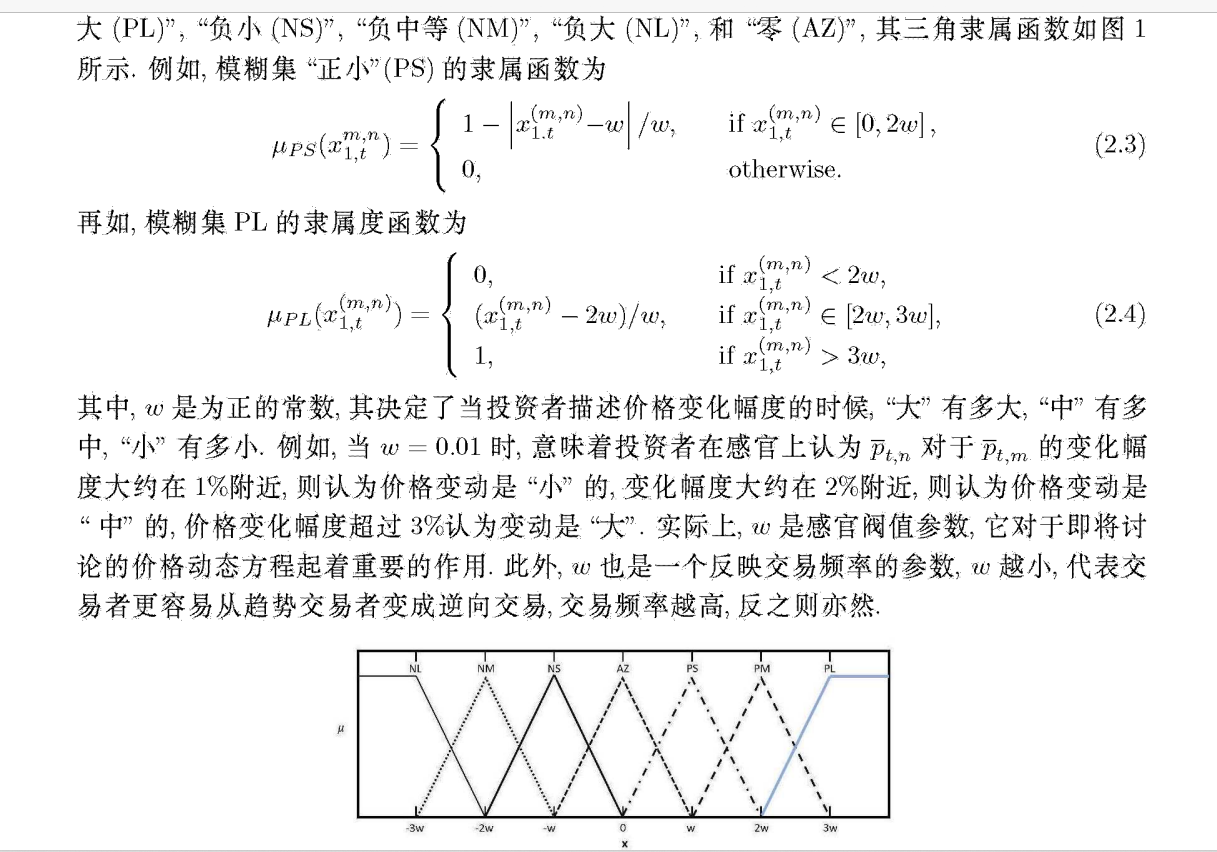

In [417]:
w=0.05#0.01
def Unl(x):#负大
    if x<=(-2*w) and x>=(-3*w):
        yi=-(x+(2*w))/w
    elif x>(-2*w):
        yi=0
    elif x<(-3*w):
        yi=1   
    return yi  

def Unm(x):#负中等
    if x>=(-3*w) and x<=-w:
        yi=1-abs(x+2*w)/w
    else:
        yi=0
    return yi 

def Uns(x):#负小
    if x>=(-2*w) and x<=0:
        yi=1-abs(x+w)/w
    else:
        yi=0
    return yi 

def Ups(x):#正小
    if x>=0 and x<=(2*w):
        yi=1-abs(x-w)/w
    else:
        yi=0
    return yi 

def Upm(x):#正中等
    if x>=w and x<=(3*w):
        yi=1-abs(x-2*w)/w
    else:
        yi=0
    return yi 

def Uaz(x):#0
    if x>=-w and x<=w:
        yi=1-abs(x)/w
    else:
        yi=0
    return yi 


def Upl(x):
    if x>=(2*w) and x<=(3*w):
        yi=(x-(2*w))/w
    elif x<(2*w):
        yi=0
    elif x>(3*w):
        yi=1   
    return yi    

### 买卖信号模糊集隶属度函数

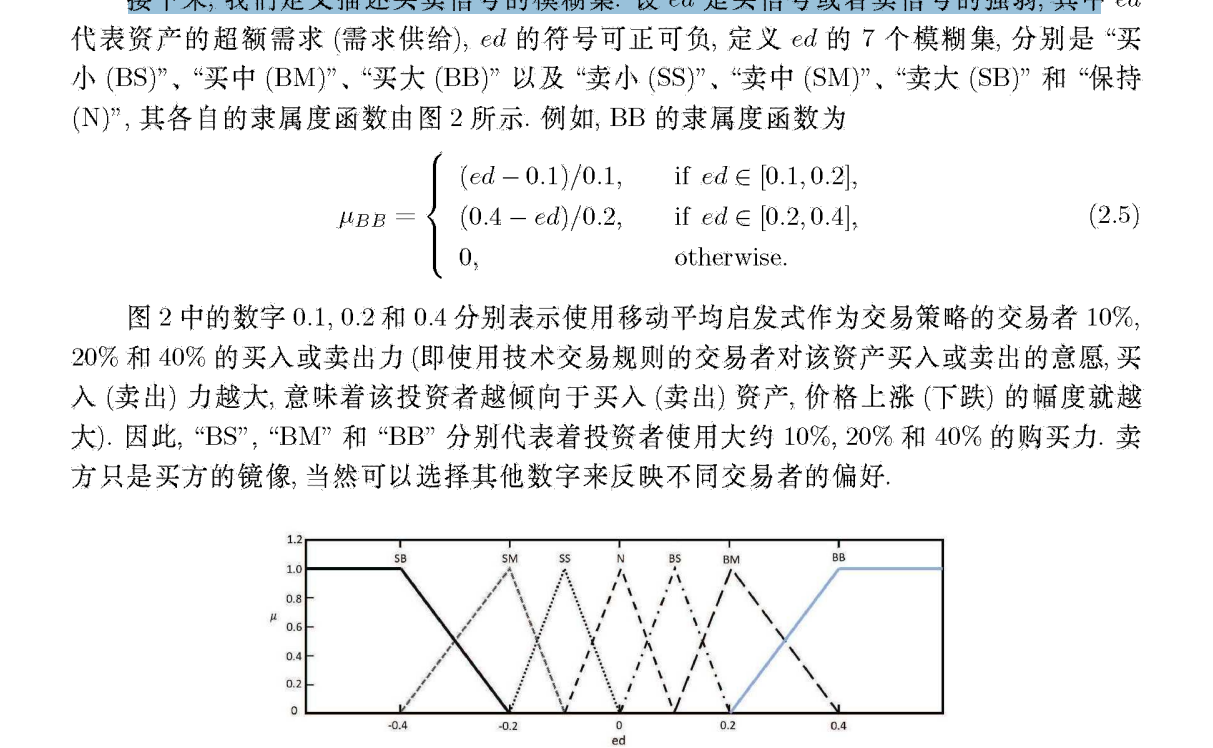

In [ ]:
def Usb(x):
    if x<=-0.2 and x>=-0.4:
        yi=-(x+0.2)*5
    elif x>-0.2:
        yi=0
    elif x<-0.4:
        yi=1   
    return yi  

def Usm(x):
    if x>=-0.4 and x<=-0.2:
        yi=5*(x+0.4)
    elif x>=-0.2 and x<=-0.1:
        yi=-10*(x+0.1)
    else:
        yi=0
    return yi 

def Uss(x):
    if x>=-0.2 and x<=0:
        yi=1-abs(x+0.1)*10
    else:
        yi=0
    return yi 

def Un(x):
    if x>=-0.1 and x<=0.1:
        yi=1-abs(x)*10
    else:
        yi=0
    return yi 

def Ubs(x):
    if x>=0 and x<=0.2:
        yi=1-abs(x-0.1)*10
    else:
        yi=0
    return yi 


def Ubm(x):
    if x>=0.1 and x<=0.2:
        yi=10*(x+0.1)
    elif x>=0.2 and x<=0.4:
        yi=-5*(x-0.4)
    else:
        yi=0
    return yi 


def Ubb(x):
    if x>=0.2 and x<=0.4:
        yi=(x-0.2)*5
    elif x<0.2: 
        yi=0
    elif x>0.4:
        yi=1   
    return yi    

In [542]:
GML5=[[[0.5,0.5],[0.455,0.545],[0.41,0.59],[0.347,0.653],[0.32,0.68],[0.275,0.725],[0.23,0.77],[0.185,0.815],[0.14,0.86],[0.095,0.905],[0.05,0.95],[0,1]],
     [[0.545,0.455],[0,0], [0,0],[0,0],[0,0],[0,0],[0,0], [0,0],[0,0],[0,0],[0,0],[0,0]],
     [[0.59,0.41],[0,0], [0,0],[0,0],[0,0],[0,0],[0,0],  [0,0],[0,0],[0,0],[0,0],[0,0]],
     [[0.653,0.347],[0,0], [0,0],[0,0],[0,0],[0,0],[0,0], [0,0],[0,0],[0,0],[0,0],[0,0]],
     [[0.68,0.32],[0,0], [0,0],[0,0],[0,0],[0,0],[0,0], [0,0],[0,0],[0,0],[0,0],[0,0]],
     [[0.725,0.275],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]],
     [[0.77,0.23],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],      [0,0],[0,0],[0,0],[0,0],[0,0]],
     [[0.815,0.185],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],    [0,0],[0,0],[0,0],[0,0],[0,0]],
     [[0.86,0.14],[0,0], [0,0],[0,0],[0,0],[0,0],[0,0],            [0,0], [0,0],[0,0],[0,0],[0,0]],
     [[0.905,0.095],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],           [0,0],[0,0],[0,0],[0,0],[0,0]],
     [[0.95,0.05],[0.81,0.043], [0,0],[0,0],[0,0],[0,0],[0,0],   [0,0],[0,0],[0,0],[0,0],[0,0]],
     [[1,0],[0.86,0],[0.72,0],[0.58,0],[0.44,0],[0.30,0],[0.16,0],  [0,0],[0,0],[0,0],[0,0],[0,0]]]#12*12
for i in range(1,12):
    for j in range(1,12):
        if i<=6 or j<=6:
            GML5[i][j][0]=GML5[i][j-1][0]-GML5[i][j-1][0]/7
            GML5[i][j][1]=GML5[i][j-1][1]-GML5[i][j-1][1]/7
        


### 制定关联规则，绘制规则热力图

In [1230]:
PPO=np.random.random((7,7))
# type(PPO[0][0])
# PPO[]
for i in range(7):
    for j in range(7):
        PPO[6-i][j]=1-(i+j)/14
PPO
# 设置字体格式
plt.rc('font', family='Times New Roman')
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
# 绘制热力图
h = sns.heatmap(
            data=PPO,# 指定绘图数据
            cmap='YlGnBu', # 指定填充色'PuBuGn'，，jet
            # center=1,
            linewidths=.1, # 设置每个单元格边框的宽度
            annot=False, # 显示数值
            cbar=False,
            # fmt='.3f',# 以科学计算法显示数据
            vmax=1,
            vmin=0,
            xticklabels=["SB","SM","SS","N","BB","BM","BS"],#["PL","PM","PS","AZ","NS","NM","NL"]
            yticklabels=["BS","BM","BB","N","SS","SM","SB"],#["BS","BM","BB","N","SS","SM","SB"]
            )
# ------------设置颜色条刻度字体的大小-------------------------#
cb = h.figure.colorbar(h.collections[0]) #显示colorbar
cb.ax.tick_params(labelsize=20)  # 设置colorbar刻度字体大小。

# 添加标题, fontweight='bold'
# plt.title('AAA', fontsize=35) # 'WS(m/s)'  u'T(°C)'  'P(mbar)'
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.xlabel('longitude', fontsize=34)  # 经度
# plt.ylabel('latitude', fontsize=34)   # 纬度
plt.rcParams['savefig.dpi'] = 600
plt.tight_layout()
# plt.savefig('D:\\Data\\aaa')

# 显示图形
plt.show()


x1=[0,50,100,150,200,250]#正向指标的阈值区间划分
x2=[1500,900,600,400,300,0]#负向指标的阈值区间划分
y=[0,0.2,0.4,0.6,0.8,1]#；隶属度区间
s=Member_dgre(x1,y,30)
print(s)
t=Member_dgre(x2,y,870)
print(t)

### apriori决策系统：根据规则决策黄金与比特币分别的购买情况：调仓比例与观望还是卖出，计算总资产与指标

In [1068]:
Pn3=[]#长度为n的比特币移动平均值
Pn4=[]#长度为n的黄金移动平均值
Pm3=[]#长度为m的比特币移动平均值
Pm4=[]#长度为m的黄金移动平均值
Xp3=[]#比特币移动平均值相对变化   正的意味着价格呈现上涨的趋势 ，而负的意味着价格的下跌趋势． 
Xp4=[]#黄金移动平均值相对变化
ZF3=[]#比特币涨幅
ZF4=[]#黄金涨幅
m=1#1表示自身
n=10#前5个指标
SP3=[]#比特币趋势模糊
SPz3=[]#涨幅模糊
SP4=[]#黄金趋势n模糊
SPz4=[]#涨幅模糊
QD3=[]#比特币购物清单
QD4=[]#黄金购物清单
max1=0
max2=0
QDl3=[]
QDl4=[]
GML3=[11,9,7,5,3,1,-0.3]#比特币购买力
GML4=[11,9,7,5,3,1,-0.3]#黄金购买力      [12,10,8,6,4,2,0](比特币,黄金)
GML6=[[[0.5, 0.5], [0.455, 0.545], [0.41, 0.59], [0.347, 0.653], [0.32, 0.68], [0.275, 0.725], [0.23, 0.77], [0.185, 0.815], [0.14, 0.86], [0.095, 0.905], [0.05, 0.95], [0, 1]],
[[0.545, 0.455], [0.4671428571428572, 0.39], [0.40040816326530615, 0.3342857142857143], [0.3432069970845481, 0.28653061224489795], [0.2941774260724698, 0.24559766763848395], [0.2521520794906884, 0.21051228654727194], [0.2161303538491615, 0.18043910275480451], [0.18525458901356698, 0.15466208807554674], [0.15878964772591456, 0.13256750406475434], [0.1361054123364982, 0.11362928919836086], [0.11666178200271274, 0.09739653359859503], [0.09999581314518236, 0.08348274308451002]], 
[[0.59, 0.41], [0.5057142857142857, 0.3514285714285714], [0.433469387755102, 0.30122448979591837], [0.37154518950437315, 0.2581924198250729], [0.3184673052894627, 0.22130778842149107], [0.2729719759623966, 0.18969239007556377], [0.23397597939633993, 0.1625934772076261], [0.20055083948257707, 0.13936583760653665], [0.17190071955649464, 0.11945643223417426], [0.14734347390556682, 0.10239122762929223], [0.12629440620477156, 0.0877639093965362], [0.10825234817551849, 0.07522620805417388]], 
[[0.653, 0.347], [0.5597142857142857, 0.29742857142857143], [0.47975510204081634, 0.2549387755102041], [0.4112186588921283, 0.2185189504373178], [0.3524731361932528, 0.18730195751770098], [0.3021198310227881, 0.16054453501517227], [0.2589598551623898, 0.13760960144157622], [0.22196559013919126, 0.11795108694992247], [0.1902562201193068, 0.10110093167136211], [0.16307676010226296, 0.0866579414325961], [0.13978008008765397, 0.0742782355136538], [0.11981149721798912, 0.06366705901170326]],
[[0.68, 0.32], [0.5828571428571429, 0.2742857142857143], [0.4995918367346939, 0.23510204081632655], [0.4282215743440233, 0.20151603498542275], [0.36704706372344853, 0.17272802998750522], [0.31461176890581305, 0.14805259713214733], [0.2696672304906969, 0.12690222611326915], [0.23114334042059737, 0.10877333666851641], [0.19812286321765488, 0.09323428857301407], [0.16981959704370417, 0.07991510449115491], [0.14555965460888928, 0.0684986609924185], [0.1247654182361908, 0.05871313799350157]],
[[0.725, 0.275], [0.6214285714285714, 0.23571428571428574], [0.5326530612244899, 0.20204081632653065], [0.45655976676384846, 0.1731778425655977], [0.3913369429404415, 0.1484381507705123], [0.3354316653775213, 0.12723270066043912], [0.2875128560378754, 0.10905660056609068], [0.24643959088960748, 0.0934770861995063], [0.21123393504823498, 0.08012321674243397], [0.18105765861277284, 0.06867704292208626], [0.15519227881094816, 0.05886603679035965], [0.133021953266527, 0.05045660296316541]], 
[[0.77, 0.23], [0.66, 0.19714285714285715], [0.5657142857142857, 0.1689795918367347], [0.4848979591836735, 0.1448396501457726], [0.4156268221574344, 0.12414827155351937], [0.3562515618492295, 0.10641280418873089], [0.30535848158505385, 0.09121097501891219], [0.2617358413586176, 0.07818083573049617], [0.2243450068788151, 0.06701214491185385], [0.1922957201818415, 0.05743898135301759], [0.16482490301300698, 0.04923341258830079], [0.14127848829686313, 0.042200067932829245]], 
[[0.815, 0.185], [0.6985714285714285, 0.15857142857142856], [0.5987755102040816, 0.13591836734693877], [0.5132361516034986, 0.11650145772594751], [0.43991670137442734, 0.09985839233652644], [0.3770714583209377, 0.08559290771702266], [0.3232041071322323, 0.0733653494717337], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]], 
[[0.86, 0.14], [0.7371428571428571, 0.12000000000000001], [0.6318367346938775, 0.10285714285714287], [0.5415743440233235, 0.08816326530612247], [0.46420658059142017, 0.07556851311953354], [0.39789135479264587, 0.06477301124531447], [0.34104973267941074, 0.05551972392455526], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]], 
[[0.905, 0.095], [0.7757142857142858, 0.08142857142857143], [0.6648979591836736, 0.06979591836734694], [0.5699125364431488, 0.059825072886297376], [0.4884964598084132, 0.05127863390254061], [0.41871125126435416, 0.043953114773606236], [0.3588953582265893, 0.03767409837737677], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]], 
[[0.95, 0.05], [0.8142857142857143, 0.04285714285714286], [0.6979591836734694, 0.036734693877551024], [0.5982507288629738, 0.03148688046647231], [0.5127863390254062, 0.026988754685547692], [0.4395311477360624, 0.02313321830189802], [0.37674098377376775, 0.019828472830198302], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]],
[[1, 0], [0.8571428571428572, 0.0], [0.7346938775510204, 0.0], [0.6297376093294461, 0.0], [0.5397750937109538, 0.0], [0.46266436603796035, 0.0], [0.39656945660396603, 0.0],      [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]] 

#三天涨幅最值倒数,用于归一化涨幅
WW=0.3#隶属度函数端值
maxZF3=0.45
maxZF4=0.066
minZF3=-0.02
minZF4=-0.01
ZF3o=[]
ZF4o=[]

Pg=0
Pb=0
Ygold = 0.003
Ybitcoin = 0.006
FA=[1000,0,0,0]#0:C 1:G 2:B

GCB=1000#现金
GGS=0#股数
SXF=0#手续费
BGS=0#股数
gold=df_month4
bitcoin=df_month3
FA=[1000,0,0,0]#0:C 1:G 2:B
HHH=0#总资产
SYL=0#年化收益率
PJSY3=[]#比特平均收益率
PJSY4=[]#黄金平均收益率
STD3=[]#比特币标准差
STD4=[]#黄金标准差
print1=0
print3=0
print2=0
x1=[]
y2=[]
y3=[]
y4=[]
y5=[]
import math
# S3=0
# S4=0
for i in range(0,1824):
    S3=0
    S4=0
    for j in range(n):
        S4=S4+df_month4["USD (PM)"][i-j]
        S3=S3+df_month3["Value"][i+1-j]
    Pn4.append(S4/n)
    Pn3.append(S3/n)
    S3=0
    S4=0
    for j in range(m):
        S4=S4+df_month4["USD (PM)"][i-j]
        S3=S3+df_month3["Value"][i+1-j]
    Pm4.append(S4/m)
    Pm3.append(S3/m)
    #涨幅计算 (b-a)/a-0.01: 涨幅
    for c in range(min(3,1824-i)):
        po3=(df_month3["Value"][i+2+c]-df_month3["Value"][i+1])/df_month3["Value"][i+1]
        po4=(df_month4["USD (PM)"][i+1+c]-df_month4["USD (PM)"][i])/df_month4["USD (PM)"][i]
        max1=0
        max2=0
        if po3>=max1:
            max1=po3
        if po4>=max2:
            max2=po4
    ZF3.append(max1-Ybitcoin/2)
    ZF4.append(max2-Ygold/2)
    mm=math.log((Pm3[i]/Pn3[i]))
    mn=math.log((Pm4[i]/Pn4[i]))
    if math.log((Pm3[i]/Pn3[i]))<0:
        mm=math.log((Pm3[i]/Pn3[i]))/15
    if math.log((Pm4[i]/Pn4[i]))>0:
        mn=math.log((Pm4[i]/Pn4[i]))*5
    Xp3.append(mm)
    Xp4.append(mn)
    #比特币模糊
    ZF3o.append(ZF3[i])
    ZF4o.append(ZF4[i])
#     ZF3o.append(1.0 /( 1 + np.exp(-ZF3[i])))
#     ZF4o.append(1.0 /( 1 + np.exp(-ZF4[i])) )
#     ZF3o.append(((ZF3[i]-minZF3)/(maxZF3-minZF3))-WW)#数据偏移  
#     ZF4o.append(((ZF4[i]-minZF4)/(maxZF4-minZF4))-WW)#-(maxZF4-minZF4)/2  0.29323413470897375 -0.045454545454545456
    SP3.append([Upl(Xp3[i]),Upm(Xp3[i]),Ups(Xp3[i]),Uaz(Xp3[i]),Uns(Xp3[i]),Unm(Xp3[i]),Unl(Xp3[i])])#趋势
    SPz3.append([Ubs(ZF3o[i]),Ubm(ZF3o[i]),Ubb(ZF3o[i]),Uss(ZF3o[i]),Usm(ZF3o[i]),Usb(ZF3o[i]),Un(ZF3o[i])])#涨幅
    #黄金模糊
    SP4.append([Upl(Xp4[i]),Upm(Xp4[i]),Ups(Xp4[i]),Uaz(Xp4[i]),Uns(Xp4[i]),Unm(Xp4[i]),Unl(Xp4[i])])
    SPz4.append([Ubs(ZF4o[i]),Ubm(ZF4o[i]),Ubb(ZF4o[i]),Uss(ZF4o[i]),Usm(ZF4o[i]),Usb(ZF4o[i]),Un(ZF4o[i])])
    #购物清单整理
        #增长趋势
    pl1=0
    pl2=0
# frozenset({4}) --> frozenset({11}) 	conf: 0.8190988567585743
# frozenset({3}) --> frozenset({11}) 	conf: 0.8434125269978402
# frozenset({5}) --> frozenset({11}) 	conf: 0.8024539877300613
# frozenset({4, 5}) --> frozenset({11}) 	conf: 0.8034610630407911
# frozenset({3, 4}) --> frozenset({11}) 	conf: 0.8377581120943953
# frozenset({2}) --> frozenset({9}) 	conf: 0.8190988567585743
# frozenset({6}) --> frozenset({9}) 	conf: 0.8190988567585743  
    for k in range(7):
        if SP3[i][k]>0.25:  
            pl1+=1
            QDl3.append(k+1)
#             Pb+=GML3[k]
        if SP4[i][k]>0.25:
            pl2+=1
            QDl4.append(k+1)
#             Pg+=GML4[k]        
    #决策
#     print(QDl3,'\n')
    if ( (2 or 3) in QDl3):#len(QDl3)==1
        print1+=1
        Pb=70   #8
    elif((4 or 5) in QDl3 ):#[4,5]
        print2+=1
        Pb=20  #11
    else:
        print3+=1
        Pb=50
    if ( (5 or 3 )in QDl4):#3 4
        Pg=20 #11
    elif((2 or 6) in QDl4):#[0] in [2,6]
        Pg=90  #9  买中
    else:
        Pg=50
#     print('Pg:',Pg,int(Pg),'pl2:',pl2,'   Pb:',Pb,'pl1:',pl1,'\n')
    pl1=0
    pl2=0
    Sell3=0#当天卖出价格
    Buy3=0#买入价格
    Sell4=0
    Buy4=0
    PPPO=(Pb+Pg)
#     Pg=Pg/PPPO  #GML6[int(Pg)][int(Pb)][1]
#     Pb=Pb/PPPO #GML6[int(Pg)][int(Pb)][0]
    HHH=GGS*gold['USD (PM)'][i]+BGS*bitcoin['Value'][i+1]+GCB#总的钱
    if Pg>50 or Pb>50:#换仓或者买入     
        print1+=1
        Pg=Pg/PPPO  #GML6[int(Pg)][int(Pb)][1]
        Pb=Pb/PPPO #GML6[int(Pg)][int(Pb)][0]
        if ((i%7)!=6) and  ((i%7)!=5):#工作日
           #         HHH=GGS*gold['USD (PM)'][i]+BGS*bitcoin['Value'][i+1]+GCB#总的钱
            SXF=abs(BGS*bitcoin['Value'][i+1]-HHH*Pb)*Ybitcoin/2+abs(GGS*gold['USD (PM)'][i]-HHH*Pg)*Ygold/2#手续费
            GCB=0  # HHH*(1-Pb-Pg)#现金
            HHH=HHH-SXF#总资产变化 减少
            BGS=Pb*HHH/bitcoin['Value'][i+1]
            GGS=Pg*HHH/gold['USD (PM)'][i]#股数变化
            FA[2]=BGS*bitcoin['Value'][i+1]
            FA[1]=gold['USD (PM)'][i]*GGS
            FA[0]=GCB
            gold.index[i]
        else:#非工作日 黄金不能买卖
            if Pb>=0.5:  #买入
                BGS+=GCB*(1-Ybitcoin/2)/bitcoin['Value'][i+1]#股数变化
                GGS=GGS#股数不变
                GCB=0#现金
                FA[2]=BGS*bitcoin['Value'][i+1]
                FA[1]=gold['USD (PM)'][i]*GGS
                FA[0]=GCB
            elif Pb<0.5:  #卖出
                
                GGS=GGS#股数不变
                GCB+=BGS*bitcoin['Value'][i+1]*(1-Ybitcoin/2)#现金
                BGS=0#股数变化
                FA[2]=BGS*bitcoin['Value'][i+1]
                FA[1]=gold['USD (PM)'][i]*GGS
                FA[0]=GCB                
    elif Pg==50 or Pb==50:#卖出
        if  Pg==50 and Pb==50:#都不变
            GGS=GGS
            BGS=BGS
            GCB=GCB
            FA[2]=FA[2]
            FA[1]=FA[1]
            FA[0]=FA[0]
        elif Pb<50 and Pg==50:#卖比特币
            GGS=GGS#股数不变
            GCB+=BGS*bitcoin['Value'][i+1]*(1-Ybitcoin/2)#现金
            BGS=0#股数变化
            FA[2]=BGS*bitcoin['Value'][i+1]
            FA[1]=gold['USD (PM)'][i]*GGS
            FA[0]=GCB
        elif Pb==50 and Pg<50:#卖黄金
            if ((i%7)!=6) and  ((i%7)!=5):#工作日
                BGS=BGS
                GCB+=gold['USD (PM)'][i]*GGS*(1-Ygold/2)
                GGS=0
                FA[2]=BGS*bitcoin['Value'][i+1]
                FA[1]=gold['USD (PM)'][i]*GGS
                FA[0]=GCB
    elif Pg<50 and Pb<50:#卖出
        if ((i%7)!=6) and  ((i%7)!=5):#工作日
            GCB=GCB+GGS*gold['USD (PM)'][i]*(1-Ygold/2)#变现
            GGS=0
            GZT=0#观望状态
            GCB=GCB+BGS*bitcoin['Value'][i+1]*(1-Ybitcoin/2)#变现
            BGS=0
            BZT=0#观望状态
            FA[2]=BGS*bitcoin['Value'][i+1]
            FA[1]=gold['USD (PM)'][i]*GGS
            FA[0]=GCB
        else:#非工作日 黄金不能买卖
            GGS=GGS#股数不变
            GCB+=BGS*bitcoin['Value'][i+1]*(1-Ybitcoin/2)#现金
            BGS=0#股数变化
            FA[2]=BGS*bitcoin['Value'][i+1]
            FA[1]=gold['USD (PM)'][i]*GGS
            FA[0]=GCB
    FA[3]=HHH
    y3.append(FA[3])
    y4.append(GGS)
    y5.append(BGS)
    x1.append(gold.index[i])
#     print(Pb,Pg)
    print(i,':',GCB,GGS,BGS,'  ',FA,'\n')#"佣金：",Ygold*gold['USD (PM)'][i]
    
    Pg=0
    Pb=0
        #增长幅度 未来值
    for k1 in range(7):
        if k1==4:   #12
            if SPz3[i][k1]>0:
                QDl3.append(k1+8)
            if SPz4[i][k1]>0:
                QDl4.append(k1+8)
        elif k1==5: #13
            if SPz3[i][k1]>0:
                QDl3.append(k1+8)
            if SPz4[i][k1]>0:
                QDl4.append(k1+8)
        else:
            if SPz3[i][k1]>0:
                QDl3.append(k1+8)
                
            if SPz4[i][k1]>0:
                QDl4.append(k1+8)
    if len(QDl3):
        QD3.append(QDl3)
    if len(QDl4):    
        QD4.append(QDl4)
    QDl3=[]
    QDl4=[]
# SPz3
SYL=pow(HHH/1000,1/5)-1 
SS=y3
SS=[(SS1-min(SS))/(max(SS)-min(SS)) for SS1 in SS] #归一化
BZ=np.std([x for x in SS], ddof = 1)#/1000
XPB=(SYL-0.0202)/BZ
print(SYL,BZ,XPB)
# print(print1,print2,print3)
w2=x1
ins=x1
values1=y3
v2=y3#list(df_month5['USD (PM)'])

0 : 1000 0 0    [1000, 0, 0, 1000.0] 

1 : 1000 0 0    [1000, 0, 0, 1000.0] 

2 : 1000 0 0    [1000, 0, 0, 1000.0] 

3 : 1000 0 0    [1000, 0, 0, 1000.0] 

4 : 1000 0 0    [1000, 0, 0, 1000.0] 

5 : 1000 0 0    [1000, 0, 0, 1000.0] 

6 : 1000 0 0    [1000, 0, 0, 1000.0] 

7 : 1000.0 0 0    [1000.0, 0.0, 0.0, 1000.0] 

8 : 1000.0 0 0    [1000.0, 0.0, 0.0, 1000.0] 

9 : 1000.0 0 0    [1000.0, 0.0, 0.0, 1000.0] 

10 : 0 0.609910689984824 0.30379945058517466    [0, 816.7314049586778, 181.49586776859502, 998.2272727272727] 

11 : 0 0.6093256437215501 0.30511183415920523    [0, 815.6737729678531, 181.26083843730066, 996.9346114051536] 

12 : 183.69818160882465 0.6093256437215501 0    [183.69818160882465, 815.6737729678531, 0.0, 999.9247073799139] 

13 : 183.69818160882465 0.6093256437215501 0    [183.69818160882465, 815.6737729678531, 0.0, 999.3719545766778] 

14 : 183.69818160882465 0.6093256437215501 0    [183.69818160882465, 816.8010254087378, 0.0, 1000.4992070175624] 

15 : 183.698181608

353 : 0 0.7483967931426786 0.11901621007714683    [0, 981.7094934049087, 545.3941630027269, 1527.1036564076355] 

354 : 0 0.6698086888504908 0.1400478519691821    [0, 884.4153927581882, 687.878638811924, 1572.294031570112] 

355 : 639.5490074772534 0.6698086888504908 0    [639.5490074772534, 884.4153927581882, 0.0, 1525.8888205187232] 

356 : 639.5490074772534 0.6698086888504908 0    [639.5490074772534, 884.4153927581882, 0.0, 1523.9644002354416] 

357 : 0 0.9396992180903413 0.06408249825254864    [0, 1252.7130276362338, 278.380672808052, 1531.0937004442858] 

358 : 0 0.9450436201270114 0.062485171100247934    [0, 1262.15300686063, 280.4784459690289, 1542.6314528296589] 

359 : 0 0.9407697743999675 0.06378325616054437    [0, 1258.6088426809963, 279.6908539291103, 1538.2996966101066] 

360 : 0 0.9504882398968036 0.06096549177805684    [0, 1276.9809503013557, 283.77354451141235, 1560.754494812768] 

361 : 0 0.9373446224651304 0.06505184812766455    [0, 1261.9001979936818, 280.42226622081

687 : 1896.9085698865792 1.1409544538703327 0    [1896.9085698865792, 1393.0483404529828, 0.0, 3289.956910339562] 

688 : 1896.9085698865792 1.1409544538703327 0    [1896.9085698865792, 1390.8234792679355, 0.0, 3287.7320491545147] 

689 : 1896.9085698865792 1.1409544538703327 0    [1896.9085698865792, 1386.7730909566958, 0.0, 3283.681660843275] 

690 : 1896.9085698865792 1.1409544538703327 0    [1896.9085698865792, 1387.7429022424856, 0.0, 3284.651472129065] 

691 : 1896.9085698865792 1.1409544538703327 0    [1896.9085698865792, 1387.7429022424856, 0.0, 3284.651472129065] 

692 : 1896.9085698865792 1.1409544538703327 0    [1896.9085698865792, 1387.7429022424856, 0.0, 3284.651472129065] 

693 : 1896.9085698865792 1.1409544538703327 0    [1896.9085698865792, 1380.155555124248, 0.0, 3277.0641250108274] 

694 : 1896.9085698865792 1.1409544538703327 0    [1896.9085698865792, 1383.2361321496978, 0.0, 3280.144702036277] 

695 : 1896.9085698865792 1.1409544538703327 0    [1896.9085698865792, 1

1024 : 1349.7948981285392 1.902061769877825 0    [1349.7948981285392, 2688.564311722306, 0.0, 4038.359209850845] 

1025 : 1349.7948981285392 1.902061769877825 0    [1349.7948981285392, 2688.564311722306, 0.0, 4041.022096328674] 

1026 : 1349.7948981285392 1.902061769877825 0    [1349.7948981285392, 2641.298076740842, 0.0, 3991.0929748693816] 

1027 : 1349.7948981285392 1.902061769877825 0    [1349.7948981285392, 2641.298076740842, 0.0, 3991.0929748693816] 

1028 : 1349.7948981285392 1.902061769877825 0    [1349.7948981285392, 2641.298076740842, 0.0, 3991.0929748693816] 

1029 : 1349.7948981285392 1.902061769877825 0    [1349.7948981285392, 2663.0766840059428, 0.0, 4012.871582134482] 

1030 : 0 1.1941547638259988 0.1889386316212431    [0, 1661.7260616020685, 2326.416486242896, 3988.142547844964] 

1031 : 0 1.201156443987444 0.18815170107799803    [0, 1691.5886200675175, 2368.2240680945242, 4059.8126881620415] 

1032 : 0 1.201156443987444 0.18815170107799803    [0, 1691.5886200675175, 23

1396 : 0 1.6468918609294327 0.07025213304539349    [0, 2984.332741190225, 663.1850535978277, 3647.5177947880525] 

1397 : 647.0450391131909 1.6468918609294327 0    [647.0450391131909, 2969.51071444186, 0.0, 3618.502729600527] 

1398 : 647.0450391131909 1.6468918609294327 0    [647.0450391131909, 2969.51071444186, 0.0, 3616.5557535550506] 

1399 : 647.0450391131909 1.6468918609294327 0    [647.0450391131909, 2969.51071444186, 0.0, 3616.5557535550506] 

1400 : 647.0450391131909 1.6468918609294327 0    [647.0450391131909, 2976.75703862995, 0.0, 3623.8020777431407] 

1401 : 647.0450391131909 1.6468918609294327 0    [647.0450391131909, 2967.534444208745, 0.0, 3614.5794833219356] 

1402 : 647.0450391131909 1.6468918609294327 0    [647.0450391131909, 2971.981052233254, 0.0, 3619.026091346445] 

1403 : 647.0450391131909 1.6468918609294327 0    [647.0450391131909, 2977.0864170021355, 0.0, 3624.1314561153263] 

1404 : 647.0450391131909 1.6468918609294327 0    [647.0450391131909, 2976.51000485081

1750 : 4702.816434064473 0 0    [4702.816434064473, 0.0, 0.0, 4702.816434064473] 

1751 : 4702.816434064473 0 0    [4702.816434064473, 0.0, 0.0, 4702.816434064473] 

1752 : 4702.816434064473 0 0    [4702.816434064473, 0.0, 0.0, 4702.816434064473] 

1753 : 4702.816434064473 0 0    [4702.816434064473, 0.0, 0.0, 4702.816434064473] 

1754 : 4702.816434064473 0 0    [4702.816434064473, 0.0, 0.0, 4702.816434064473] 

1755 : 4702.816434064473 0 0    [4702.816434064473, 0.0, 0.0, 4702.816434064473] 

1756 : 4702.816434064473 0 0    [4702.816434064473, 0.0, 0.0, 4702.816434064473] 

1757 : 4702.816434064473 0 0    [4702.816434064473, 0.0, 0.0, 4702.816434064473] 

1758 : 0 2.1222409997824325 0.025291647161501604    [0, 3840.937873456235, 853.5417496569413, 4694.479623113177] 

1759 : 862.6570355767273 2.1222409997824325 0    [862.6570355767273, 3829.902220257367, 0.0, 4695.15501421597] 

1760 : 862.6570355767273 2.1222409997824325 0    [862.6570355767273, 3836.3750553067034, 0.0, 4699.032090883

##### 绘制股数线

In [1228]:
# y2.append(Pb)
# y3.append(Pg)

# 画第2个图：散点图

# 画第3个图：条形图
# 前面的两个图占了221和222的位置，如果想在下面只放一个图，得把前两个当成一列，即2行1列第2个位置
ins=x1
v1=y1#list(df_month5['USD (PM)'])
values=y5
values1=y4
dictionary = dict(zip(ins, values))#列表变字典
dictionary1 = dict(zip(ins, values1))#列表变字典
df6 = pd.DataFrame(pd.Series(dictionary), columns=['fruits'])#字典变dataframe
df7 = pd.DataFrame(pd.Series(dictionary1), columns=['fruits'])#字典变dataframe

plt.figure(figsize=(15,7))
# df6["USD (PM)"].plot(label='Gjia')#实际的指数  _month3
plt.subplot(211)
df6.fruits.plot(color='b', ls='dotted', label='Percentage of bitcoin holdings')#收益率HHH
plt.legend(prop={'family' : 'Times New Roman', 'size'   : 15})
# plt.xlabel('Date',fontproperties = 'Times New Roman', size = 15)
plt.ylabel('Shares',fontproperties = 'Times New Roman', size = 15)
plt.yticks(fontproperties = 'Times New Roman', size = 15)
plt.xticks(fontproperties = 'Times New Roman', size = 15)

plt.subplot(212)
df7.fruits.plot(color='r', ls='dotted', label='Proportion of gold holdings')#收益率HHH
plt.legend(prop={'family' : 'Times New Roman', 'size'   : 15})
# plt.title('The yield',fontproperties = 'Times New Roman', size = 15)
plt.xlabel('Date',fontproperties = 'Times New Roman', size = 15)
plt.ylabel('Shares',fontproperties = 'Times New Roman', size = 15)
plt.yticks(fontproperties = 'Times New Roman', size = 15)
plt.xticks(fontproperties = 'Times New Roman', size = 15)
plt.show()
# 黄金持仓比例    Proportion of gold holdings
# 比特币持仓比例  Percentage of bitcoin holdings

总资产可视化

In [1222]:
import math
math.log(5)
ZF3.sort()


values2=Pn4
dictionary3 = dict(zip(ins, values1))#列表变字典
# dictionary4 = dict(zip(ins, values2))#列表变字典
ddict3= pd.DataFrame(pd.Series(dictionary3), columns=['fruits'])#字典变dataframe
# ddict4= pd.DataFrame(pd.Series(dictionary4), columns=['fruits'])#字典变dataframe

plt.figure(figsize=(30,7))
# df6["USD (PM)"].plot(label='Gjia')#实际的指数  _month3
ddict3.fruits.plot(color='r', ls='--', label='Total Assets')# 收益率HHH  dotted
# df_month3["Value"].plot(color='g',label='Dollar price per bitcoin per day')#实际的指数  _month3
# ddict4.fruits.plot(color='r', ls='dotted', label='The moving average of gold of length 5')#收益率HHH
# df_month4["USD (PM)"].plot(label='Dollar price per gold per day')#实际的指数  _month3

plt.legend(prop={'family' : 'Times New Roman', 'size'   : 24}) #总资产
# plt.title('The yield Index(day)',fontproperties = 'Times New Roman', size = 24)
plt.xlabel('Date',fontproperties = 'Times New Roman', size = 24)
plt.ylabel('Dollars',fontproperties = 'Times New Roman', size = 24)
plt.yticks(fontproperties = 'Times New Roman', size = 20)
plt.xticks(fontproperties = 'Times New Roman', size = 20)
plt.show()
# 黄金日价格，美元每金衡盎司
# Gold daily price,dollar per Troy ounce
# 比特币每日价格，每日每比特币的美元价格  Dollar price per bitcoin per day
# The daily price of bitcoin,the dollar price per bitcoin  5天黄金移动平均值与当天价格图  Dollar price per gold per day

### 绘制热力图

In [1090]:
PPO=np.random.random((7,7))
# type(PPO[0][0])
# PPO[]
for i in range(7):
    for j in range(7):
        PPO[6-i][j]=1-(i+j)/14
PPO
# 设置字体格式
plt.rc('font', family='Times New Roman')
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
# 绘制热力图
h = sns.heatmap(
            data=PPO,# 指定绘图数据
            cmap='YlGnBu', # 指定填充色'PuBuGn'，，jet
            # center=1,
            linewidths=.1, # 设置每个单元格边框的宽度
            annot=False, # 显示数值
            cbar=False,
            # fmt='.3f',# 以科学计算法显示数据
            vmax=1,
            vmin=0,
            xticklabels=["SB","SM","SS","N","BB","BM","BS"],#["PL","PM","PS","AZ","NS","NM","NL"]
            yticklabels=["BS","BM","BB","N","SS","SM","SB"],#["BS","BM","BB","N","SS","SM","SB"]
            )
# ------------设置颜色条刻度字体的大小-------------------------#
cb = h.figure.colorbar(h.collections[0]) #显示colorbar
cb.ax.tick_params(labelsize=20)  # 设置colorbar刻度字体大小。

# 添加标题, fontweight='bold'
# plt.title('AAA', fontsize=35) # 'WS(m/s)'  u'T(°C)'  'P(mbar)'
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.xlabel('longitude', fontsize=34)  # 经度
# plt.ylabel('latitude', fontsize=34)   # 纬度
plt.rcParams['savefig.dpi'] = 600
plt.tight_layout()
# plt.savefig('D:\\Data\\aaa')

# 显示图形
plt.show()


## 收益率指标定义

In [ ]:
年化收益率:  股票累乘
平均收益率:(P[卖]/P[买])*(佣金) #多只股票累加
标准差:
m1 m2
买: B=当前价格  S=S
卖: S=当前价格  B=B

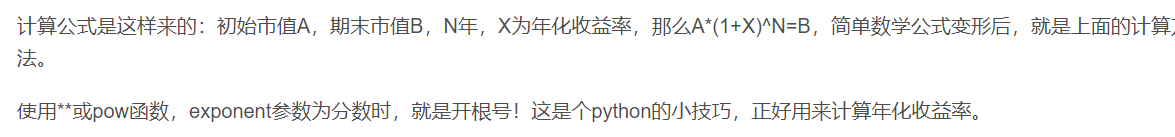

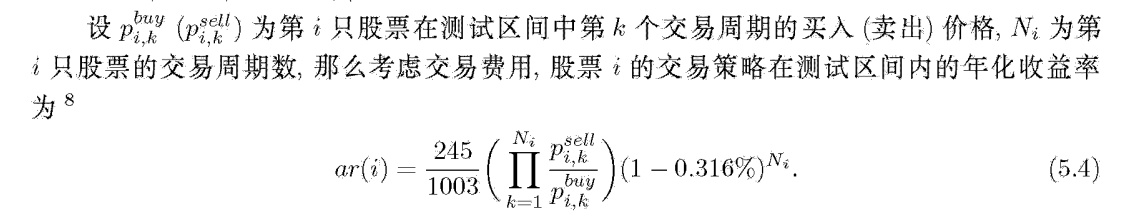
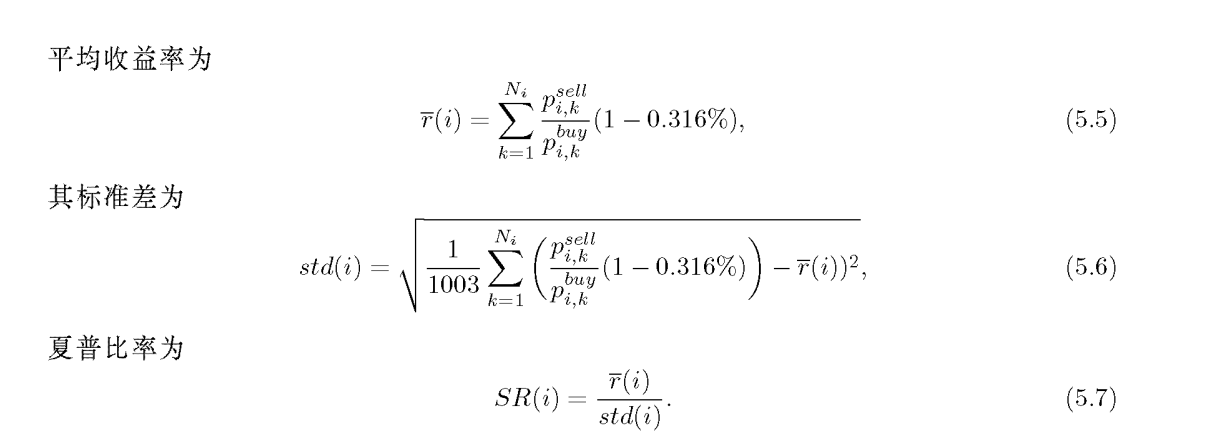


## 长期买入持有:2019年之前持有黄金,之后买入比特币持有

In [965]:
# 2019-08-29 00:00:00	 1540.2 	9717.82
# 2021-09-10 00:00:00	1794.6	46368.69
# 2016-09-12 00:00:00	1324.6	609.67
Y=1540.2*1000*(1-0.01)*(1-0.01)/1324.6/2  #19年 
Y*(1--0.02)*46368.69/9717.82+Y*1794.6/1540.2
GGS=1000*(1-0.01)/1324.6 #16年
GGS2=9*GGS*(1-0.005)/10  #19年
o=1000  #1082
BGS=(GGS-GGS2)*(1-0.02)*gold['USD (PM)'][o]/bitcoin['Value'][o+1]#19年
HHH=0
x1=[]
y2=[]
y1=[]
for i in range(0,1824):
    x1.append(df_month4.index[i])
#     x1.append(gold.index[i])
    if i <=o:
        HHH=GGS*gold['USD (PM)'][i]
        y1.append(HHH)
    elif i >o:
        HHH=BGS*bitcoin['Value'][i+1]+GGS2*gold['USD (PM)'][i]
        y1.append(HHH)
    print(i,':',HHH,'\n')

SS=y1
SS=[(SS1-min(SS))/(max(SS)-min(SS)) for SS1 in SS] #归一化
SYL1=pow(y1[-1]/1000,1/5)-1 
BZ1=np.std([x for x in SS], ddof = 1)#/1000
XPB1=(SYL1-0.0202)/BZ1
print(SYL1,BZ1,XPB1)


x3 = np.linspace(-5,5,1821)
# y1=0.06+0*x3
w3=x1
ins=x1
v3=y1#list(df_month5['USD (PM)'])
values=y1
dictionary = dict(zip(ins, values))#列表变字典
df6 = pd.DataFrame(pd.Series(dictionary), columns=['fruits'])#字典变dataframe

plt.figure(figsize=(15,7))
# df6["USD (PM)"].plot(label='Gjia')#实际的指数  _month3
df6.fruits.plot(color='g', ls='dotted', label='Total Assets')#  HHH
plt.legend(prop={'family' : 'Times New Roman', 'size'   : 24})
# plt.plot(df6.index,0.5+0*x3)
# plt.plot(df6.index,0+0*x3)
# plt.plot(df6.index,-0.5+0*x3)
# plt.title('The yield',fontproperties = 'Times New Roman', size = 24)
plt.xlabel('Date',fontproperties = 'Times New Roman', size = 24)
plt.ylabel('Dollars',fontproperties = 'Times New Roman', size = 24)
plt.yticks(fontproperties = 'Times New Roman', size = 20)
plt.xticks(fontproperties = 'Times New Roman', size = 20)
plt.show()


0 : 990.0000000000001 

1 : 989.289974331874 

2 : 987.8699229956214 

3 : 979.6859429261665 

4 : 977.854824097841 

5 : 977.854824097841 

6 : 977.854824097841 

7 : 982.7128944587046 

8 : 981.928129246565 

9 : 991.1210931601994 

10 : 1000.8372338819266 

11 : 1000.500905933867 

12 : 1000.500905933867 

13 : 1000.500905933867 

14 : 1001.8835874981128 

15 : 991.793749056319 

16 : 988.4304695757211 

17 : 985.1419296391364 

18 : 988.4304695757211 

19 : 988.4304695757211 

20 : 988.4304695757211 

21 : 981.5544315264987 

22 : 959.1325683225126 

23 : 948.7437717046657 

24 : 937.607579646686 

25 : 940.7840102672507 

26 : 940.7840102672507 

27 : 940.7840102672507 

28 : 941.3445568473503 

29 : 936.8228144345464 

30 : 939.1023705269516 

31 : 942.5030197795562 

32 : 935.5522421863205 

33 : 935.5522421863205 

34 : 935.5522421863205 

35 : 937.8317982787257 

36 : 940.3729427751775 

37 : 948.4821833006191 

38 : 950.4254114449648 

39 : 946.2399969802206 

40 : 946.239996

1050 : 1073.0572684830377 

1051 : 1077.270995137579 

1052 : 1079.5112699904878 

1053 : 1072.03505177735 

1054 : 1099.5988928310812 

1055 : 1101.1822252490645 

1056 : 1104.8697673782817 

1057 : 1122.741425846444 

1058 : 1133.1920925726263 

1059 : 1156.3291079047574 

1060 : 1155.8415636442112 

1061 : 1157.6071418439446 

1062 : 1155.7988204510575 

1063 : 1148.3670684692142 

1064 : 1156.7344837803464 

1065 : 1150.181625799366 

1066 : 1153.2876322429586 

1067 : 1144.0111440611267 

1068 : 1147.4334273326033 

1069 : 1148.1743772229277 

1070 : 1146.2994259726079 

1071 : 1135.1507508478562 

1072 : 1148.229930122582 

1073 : 1145.3324907579017 

1074 : 1136.3634947990563 

1075 : 1137.309379768179 

1076 : 1141.1109042360335 

1077 : 1137.7210617222584 

1078 : 1137.6079850321687 

1079 : 1160.0317243200095 

1080 : 1160.4061705816794 

1081 : 1156.5720534205034 

1082 : 1145.6563914483718 

1083 : 1146.8653028810925 

1084 : 1147.1617087128952 

1085 : 1147.7070129908302 


0.12387208572462138 0.25826571908592677 0.4014163633158335


## 趋势跟踪

In [1053]:
Pn3=[]#长度为n的比特币移动平均值
Pn4=[]#长度为n的黄金移动平均值
Pm3=[]#长度为m的比特币移动平均值
Pm4=[]#长度为m的黄金移动平均值
Xp3=[]#比特币移动平均值相对变化   正的意味着价格呈现上涨的趋势 ，而负的意味着价格的下跌趋势． 
Xp4=[]#黄金移动平均值相对变化
ZF3=[]#比特币涨幅
ZF4=[]#黄金涨幅
m=1#1表示自身
n=10#前5个指标
SP3=[]#比特币趋势模糊
SPz3=[]#涨幅模糊
SP4=[]#黄金趋势n模糊
SPz4=[]#涨幅模糊
QD3=[]
QD4=[]
max1=0
max2=0
QDl3=[]
QDl4=[]
x1=[]
y1=[]
y4=[]
y5=[]
Bgold=500#黄金本金
Bbitcoin=500#比特币本金

Ygold = 0.02
Ybitcoin = 0.04

GCB=1000#现金
GGS=500*(1-0.01)/df_month4["USD (PM)"][0]#股数

BGS=500*(1-0.02)/df_month3["Value"][1]#股数
gold=df_month4
bitcoin=df_month3
#三天涨幅最值倒数,用于归一化涨幅
WW=0.3#隶属度函数端值
maxZF3=0.45
maxZF4=0.066
minZF3=-0.02
minZF4=-0.01
ZF3o=[]
ZF4o=[]
import math
# S3=0
# S4=0
for i in range(0,1824):
    S3=0
    S4=0
    for j in range(n):
        S4=S4+df_month4["USD (PM)"][i-j]
        S3=S3+df_month3["Value"][i+1-j]
    Pn4.append(S4/n)
    Pn3.append(S3/n)
    S3=0
    S4=0
    for j in range(m):
        S4=S4+df_month4["USD (PM)"][i-j]
        S3=S3+df_month3["Value"][i+1-j]
    Pm4.append(S4/m)
    Pm3.append(S3/m)
    #涨幅计算 (b-a)/a-0.01: 涨幅
    for c in range(min(3,1824-i)):
        po3=(df_month3["Value"][i+2+c]-df_month3["Value"][i+1])/df_month3["Value"][i+1]
        po4=(df_month4["USD (PM)"][i+1+c]-df_month4["USD (PM)"][i])/df_month4["USD (PM)"][i]
        max1=0
        max2=0
        if po3>=max1:
            max1=po3
        if po4>=max2:
            max2=po4
    ZF3.append(max1-Ybitcoin/2)
    ZF4.append(max2-Ygold/2)
    mm=math.log((Pm3[i]/Pn3[i]))
    mn=math.log((Pm4[i]/Pn4[i]))
    if math.log((Pm3[i]/Pn3[i]))<0:
        mm=math.log((Pm3[i]/Pn3[i]))/15
    if math.log((Pm4[i]/Pn4[i]))>0:
        mn=math.log((Pm4[i]/Pn4[i]))*5
    Xp3.append(mm)
    Xp4.append(mn)
    #比特币模糊
    ZF3o.append(ZF3[i])
    ZF4o.append(ZF4[i])
#     ZF3o.append(1.0 /( 1 + np.exp(-ZF3[i])))
#     ZF4o.append(1.0 /( 1 + np.exp(-ZF4[i])) )
#     ZF3o.append(((ZF3[i]-minZF3)/(maxZF3-minZF3))-WW)#数据偏移  
#     ZF4o.append(((ZF4[i]-minZF4)/(maxZF4-minZF4))-WW)#-(maxZF4-minZF4)/2  0.29323413470897375 -0.045454545454545456
    SP3.append([Upl(Xp3[i]),Upm(Xp3[i]),Ups(Xp3[i]),Uaz(Xp3[i]),Uns(Xp3[i]),Unm(Xp3[i]),Unl(Xp3[i])])#趋势
    SPz3.append([Ubs(ZF3o[i]),Ubm(ZF3o[i]),Ubb(ZF3o[i]),Uss(ZF3o[i]),Usm(ZF3o[i]),Usb(ZF3o[i]),Un(ZF3o[i])])#涨幅
    #黄金模糊
    SP4.append([Upl(Xp4[i]),Upm(Xp4[i]),Ups(Xp4[i]),Uaz(Xp4[i]),Uns(Xp4[i]),Unm(Xp4[i]),Unl(Xp4[i])])
    SPz4.append([Ubs(ZF4o[i]),Ubm(ZF4o[i]),Ubb(ZF4o[i]),Uss(ZF4o[i]),Usm(ZF4o[i]),Usb(ZF4o[i]),Un(ZF4o[i])])
    #购物清单整理
    
    for k in range(7):
        if SP3[i][k]>0:
            QDl3.append(k+1)
        if SP4[i][k]>0:
            QDl4.append(k+1)
    for k1 in range(7):
        if k1==4:   #12
            if SPz3[i][k1]>0:
                QDl3.append(k1+8)
            if SPz4[i][k1]>0:
                QDl4.append(k1+8)
        elif k1==5: #13
            if SPz3[i][k1]>0:
                QDl3.append(k1+8)
            if SPz4[i][k1]>0:
                QDl4.append(k1+8)
        else:
            if SPz3[i][k1]>0:
                QDl3.append(k1+8)
                
            if SPz4[i][k1]>0:
                QDl4.append(k1+8)
    if len(QDl3):
        QD3.append(QDl3)
    if len(QDl4):    
        QD4.append(QDl4)
    QDl3=[]
    QDl4=[]
    
    aaa = 0.01
    if Xp3[i]>aaa:
        BGS+=Bbitcoin*(1-0.02)/df_month3["Value"][i+1]
        Bbitcoin=0
    elif Xp3[i]<-aaa:
        Bbitcoin+=BGS*df_month3["Value"][i+1]*(1-0.02)
        BGS=0
    else:
        Bbitcoin=Bbitcoin
        BGS=BGS
    if Xp4[i]>aaa:
        GGS+=Bgold*(1-0.01)/df_month4["USD (PM)"][i]
        Bgold=0
    elif Xp4[i]<-aaa:
        Bgold+=GGS*df_month4["USD (PM)"][i]*(1-0.01)
        GGS=0
    else:
        Bgold=Bgold
        GGS=GGS
    y4.append(GGS)
    y5.append(BGS)
    HHH=Bbitcoin+Bgold+BGS*df_month3["Value"][i+1]+GGS*df_month4["USD (PM)"][i]
    GCB=Bbitcoin+Bgold
    y1.append(HHH)
    x1.append(df_month4.index[i])
    print(GCB,BGS*df_month3["Value"][i+1],GGS*df_month4["USD (PM)"][i],HHH,'\n')
    
SYL1=pow(HHH/1000,1/5)-1 
SS=y1
SS=[(SS1-min(SS))/(max(SS)-min(SS)) for SS1 in SS] #归一化
BZ1=np.std([x for x in SS], ddof = 1)#/1000
XPB1=(SYL1-0.0202)/BZ1
print(SYL1,BZ1,XPB1)


x3 = np.linspace(-5,5,1824)
# y1=0.06+0*x3
w5=x1
ins=x1
values=y1
v5=y1#list(df_month5['USD (PM)'])
dictionary = dict(zip(ins, values))#列表变字典
df6 = pd.DataFrame(pd.Series(dictionary), columns=['fruits'])#字典变dataframe

plt.figure(figsize=(30,7))
# df6["USD (PM)"].plot(label='Gjia')#实际的指数  _month3
df6.fruits.plot(color='b', ls='dotted', label='Benefit')#收益率HHH
plt.legend(prop={'family' : 'Times New Roman', 'size'   : 24})
# plt.plot(df6.index,0+0*x3)
# plt.plot(df6.index,0+0*x3)
# plt.plot(df6.index,-0.5+0*x3)
plt.title('The yield',fontproperties = 'Times New Roman', size = 24)
plt.xlabel('Date',fontproperties = 'Times New Roman', size = 24)
plt.ylabel('Dollars',fontproperties = 'Times New Roman', size = 24)
plt.yticks(fontproperties = 'Times New Roman', size = 14)
plt.xticks(fontproperties = 'Times New Roman', size = 14)
plt.show()

0 980.0 990.0000000000001 1970.0 

0 995.5425212431513 986.4969909729189 1982.0395122160703 

0 1120.3486754525659 985.2557673019058 2105.6044427544716 

0 1101.0300014887675 994.164994984955 2095.1949964737223 

0 1062.2863130170808 1004.8946840521565 2067.1809970692375 

0 1064.1568431876296 1006.0531594784354 2070.210002666065 

0 1049.134752567256 1006.0531594784354 2055.1879120456915 

0 1039.218496830835 1006.0531594784354 2045.2716563092704 

0 1002.9161745703735 999.9022066198597 2002.8183811902331 

0 1001.1913309452285 999.4884653961886 2000.6797963414172 

0 1038.0279080991997 1001.1710130391175 2039.1989211383172 

0 1039.960541147497 992.1514543630894 2032.1119955105864 

0 1043.3466367524206 992.1514543630894 2035.49809111551 

0 998.8099408008703 992.1514543630894 1990.9613951639599 

0 1041.5437391679134 992.1514543630894 2033.6951935310028 

975.7308926780343 1015.4369229126546 0.0 1991.1678155906889 

975.7308926780343 1053.271187051281 0.0 2029.0020797293153 

0 1049

0 276.4913179957455 499.83726418903785 776.3285821847833 

0 271.8955666889168 493.1546350352613 765.0502017241781 

0 265.8600228199528 493.1546350352613 759.0146578552142 

0 270.4465308618844 493.1546350352613 763.6011658971457 

0 239.256674010834 497.98016593404964 737.2368399448836 

0 240.03711367697755 498.1556397849147 738.1927534618923 

0 237.22130708049679 494.70465405123576 731.9259611317325 

0 232.60737735270382 501.54813423497194 734.1555115876757 

0 231.29976347859676 501.8259678321749 733.1257313107717 

0 230.3914586480436 501.8259678321749 732.2174264802185 

0 219.71209849478606 501.8259678321749 721.5380663269609 

0 211.1321919084856 507.7774559406805 718.909647849166 

0 210.75383426536504 500.261325995295 711.0151602606601 

487.007054898414 219.68282815594532 0.0 706.6898830543594 

487.007054898414 223.66729154424704 0.0 710.6743464426611 

487.007054898414 216.75117263942113 0.0 703.7582275378352 

487.007054898414 219.13531876520824 0.0 706.1423736636223 


0 80.0595262826926 305.5811482886568 385.6406745713494 

0 77.3266802531237 306.0777206104135 383.4044008635372 

0 78.81284203274691 305.68755664331894 384.50039867606586 

0 79.8309772253086 304.7889972039497 384.61997442925826 

0 79.82887911328336 304.7889972039497 384.617876317233 

0 83.47053920372267 304.7889972039497 388.2595364076724 

0 88.32108092185655 305.4865630845127 393.80764400636923 

0 88.27973885623224 304.70623515032355 392.9859740065558 

0 88.36388255604687 304.19783967804887 392.5617222340957 

0 85.83220057286493 305.5575019876208 391.3897025604857 

0 84.4345976731905 302.64900696018873 387.0836046333792 

0 83.69036738982689 302.64900696018873 386.33937435001565 

0 84.63552452627577 302.64900696018873 387.2845314864645 

0 84.41839654311335 305.1436917194902 389.56208826260354 

0 82.1500558944508 303.35839599126973 385.50845188572055 

0 83.00990166747488 302.4361902508644 385.4460919183393 

0 82.54607134825068 302.4361902508644 384.9822615991151 

0 85.65

344.68084816983065 0.0 0.0 344.68084816983065 

344.68084816983065 0.0 0.0 344.68084816983065 

344.68084816983065 0.0 0.0 344.68084816983065 

344.68084816983065 0.0 0.0 344.68084816983065 

344.68084816983065 0.0 0.0 344.68084816983065 

344.68084816983065 0.0 0.0 344.68084816983065 

344.68084816983065 0.0 0.0 344.68084816983065 

115.83146374530868 0.0 226.56089058027678 342.3923543255855 

115.83146374530868 0.0 225.95480298597883 341.7862667312875 

115.83146374530868 0.0 225.48241118454078 341.3138749298495 

115.83146374530868 0.0 225.48241118454078 341.3138749298495 

115.83146374530868 0.0 225.48241118454078 341.3138749298495 

115.83146374530868 0.0 224.80501916738424 340.63648291269294 

336.09421291554435 0.0 0.0 336.09421291554435 

336.09421291554435 0.0 0.0 336.09421291554435 

220.26274917023565 113.51483447040249 0.0 333.7775836406381 

220.26274917023565 112.7956964140369 0.0 333.05844558427253 

220.26274917023565 107.75717043939893 0.0 328.0199196096346 

309.44744

-0.25136193925010264 0.26325268095233584 -1.0315638126369975


#### 趋势跟踪股份图

In [999]:
# y2.append(Pb)
# y3.append(Pg)

# 画第2个图：散点图

# 画第3个图：条形图
# 前面的两个图占了221和222的位置，如果想在下面只放一个图，得把前两个当成一列，即2行1列第2个位置
ins=x1
# v1=y1#list(df_month5['USD (PM)'])
values=y5
values1=y4
dictionary = dict(zip(ins, values))#列表变字典
dictionary1 = dict(zip(ins, values1))#列表变字典
df6 = pd.DataFrame(pd.Series(dictionary), columns=['fruits'])#字典变dataframe
df7 = pd.DataFrame(pd.Series(dictionary1), columns=['fruits'])#字典变dataframe

plt.figure(figsize=(15,7))
# df6["USD (PM)"].plot(label='Gjia')#实际的指数  _month3
plt.subplot(211)
df6.fruits.plot(color='b', ls='dotted', label='Percentage of bitcoin holdings')#收益率HHH
plt.legend(prop={'family' : 'Times New Roman', 'size'   : 15})
# plt.xlabel('Date',fontproperties = 'Times New Roman', size = 15)
plt.ylabel('Shares',fontproperties = 'Times New Roman', size = 15)
plt.yticks(fontproperties = 'Times New Roman', size = 15)
plt.xticks(fontproperties = 'Times New Roman', size = 15)

plt.subplot(212)
df7.fruits.plot(color='r', ls='dotted', label='Proportion of gold holdings')#收益率HHH
plt.legend(prop={'family' : 'Times New Roman', 'size'   : 15})
# plt.title('The yield',fontproperties = 'Times New Roman', size = 15)
plt.xlabel('Date',fontproperties = 'Times New Roman', size = 15)
plt.ylabel('Shares',fontproperties = 'Times New Roman', size = 15)
plt.yticks(fontproperties = 'Times New Roman', size = 15)
plt.xticks(fontproperties = 'Times New Roman', size = 15)
plt.show()
# 黄金持仓比例    Proportion of gold holdings
# 比特币持仓比例  Percentage of bitcoin holdings

In [894]:
y1[-1]

635.2395787744167

# 汇总总资产图

In [895]:

dictionary1 = dict(zip(w1, v1))#列表变字典
dictionary2 = dict(zip(w2, v2))#列表变字典
dictionary3 = dict(zip(w3, v3))#列表变字典
dictionary5 = dict(zip(w5, v5))#列表变字典
df6 = pd.DataFrame(pd.Series(dictionary1), columns=['fruits'])#字典变dataframe
df7= pd.DataFrame(pd.Series(dictionary2), columns=['fruits'])#字典变dataframe
df8 = pd.DataFrame(pd.Series(dictionary3), columns=['fruits'])#字典变dataframe
df9 = pd.DataFrame(pd.Series(dictionary5), columns=['fruits'])#字典变dataframe
plt.figure(figsize=(15,7))
# df6["USD (PM)"].plot(label='Gjia')#实际的指数  _month3
df6.fruits.plot(color='b', ls='-', label='Time-Series Analysis')# dotted
df7.fruits.plot(color='r', ls='-', label='Apriori')# 
df8.fruits.plot(color='g', ls='-', label='Buy and Hold')# 
df9.fruits.plot(color='y', ls='-', label='Trend Tracking')# 
plt.legend(prop={'family' : 'Times New Roman', 'size'   : 24})
# plt.plot(df6.index,0+0*x3)

# plt.title('The yield',fontproperties = 'Times New Roman', size = 24)
plt.xlabel('Date',fontproperties = 'Times New Roman', size = 24)
plt.ylabel('Dollars',fontproperties = 'Times New Roman', size = 24)

plt.yticks(fontproperties = 'Times New Roman', size = 20)
plt.xticks(fontproperties = 'Times New Roman', size = 20)
plt.show()

In [808]:
df8

,fruits
2016-09-12,1970.250000
2016-09-13,1970.250000
2016-09-14,1970.250000
2016-09-15,1970.250000
2016-09-16,1970.250000
...,...
2021-09-05,686.658127
2021-09-06,708.814759
2021-09-07,718.329996
2021-09-08,635.239579


In [1005]:
edd1=df_month4#["USD (PM)"]
edd2=df_month3#["Value"]
SS=list(edd1["USD (PM)"])
SS=[(SS1-min(SS))/(max(SS)-min(SS)) for SS1 in SS] #归一化
BG=np.std([x for x in SS], ddof = 1)#/1000
SS2=list(edd2["Value"])
SS=[(SS1-min(SS2))/(max(SS2)-min(SS2)) for SS1 in SS2] #归一化
BB=np.std([x for x in SS], ddof = 1)#/1000
# XPB1=(SYL1-0.0202)/BZ1

In [1011]:
print(BG,BB)
Y=BG*BG+BB*BB

0.26488609123200263 0.22305926501761303


In [1022]:
o=3
q1=pow(0.17899526610003447,o)+sqrt(abs(Y-5*(0.28838391225198373-0.2)))+sqrt(0.5506384349251859 +0.6)
q2=pow(0.39309739996061865,o)+sqrt(abs(Y-5*(0.2645264669217997-0.2)))+sqrt(1.4096789795739266 +0.6)
q3=pow(0.12387208572462138,o)+sqrt(abs(Y-5*(0.25826571908592677-0.2)))+sqrt(0.4014163633158335+0.6)
q4=pow(-0.08675456538067094,o)+sqrt(abs(Y-5*(0.2114275535933786-0.2)))+sqrt(-0.505868622906019+0.6)
print(q1/2,q2/2,q3/2,q4/2)

0.8229315139311122 0.9643054231606532 0.7083118896417971 0.2783597041552793
